<h1><center>Food for good - Applied Data Analysis project</center></h1>

![title](images/openfoodfacts.png)

## Table of content

### 1. Cleaning the data:

- Removing columns that have very high values of NaN.
- Correcting some mistakes (inputs errors).

        
### 2. Analysis and Data Visualization: 

#### A. Quality of food:

- Additives.
    - Products containing additives
- Palm oil.
    - Products containing palm oil.

- Where are these products from?
    - The represented countries in our dataset
    - Additives by country
    - Palm oil by country
    
- Nutritional values (a, b, c, d, e)
    - Distribution of nutritional values over some categories.
    - Distribution of some principal nutritional features over healthy/unhealthy products.
   
#### B. Carbon Footprint:

- the goods with the highest carbon foodprint.

### 3. Advices for customers

## 1. Cleaning the data:

In [1]:
# Importing several useful packages
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import warnings
from scipy.stats import pearsonr
warnings.filterwarnings("ignore")
import seaborn as sns
sns.set(color_codes=True)
import folium
import json
import branca.colormap as cm
from wordcloud import WordCloud, STOPWORDS


__Insights on our database:__

- Our dataset is in a csv format.
- Our dataset has a size of `1.7Gb`
- Manageable by pandas with a `\t` separator.

So we will be working with the several features of our dataset. In order to resume these features, we will categorise them as :  

- _Generalities:_ these fields contain general informations on the products of our dataset, their dates, modifications, product name, code bar of the product, the quantity, etc.
- _tags:_ these fields contain information about packaging, brands, categories, countries, stores, manufacturies and other interesting tags.
- _Ingredients:_ these fields contain features about ingredients.
- _Nutrition facts:_ these fields contain anything that relates to nutriements, macros and micros.

In [2]:
# Loading our data 
df_open_food_fact = pd.read_csv('en.openfoodfacts.org.products.csv', sep="\t", error_bad_lines=False)
df_open_food_fact.head()

code                                                url   creator  \
0  0000000000017  http://world-en.openfoodfacts.org/product/0000...   kiliweb   
1  0000000000031  http://world-en.openfoodfacts.org/product/0000...  isagoofy   
2  0000000000123  http://world-en.openfoodfacts.org/product/0000...   kiliweb   
3  0000000000291  http://world-en.openfoodfacts.org/product/0000...   kiliweb   
4  0000000000949  http://world-en.openfoodfacts.org/product/0000...   kiliweb   

    created_t      created_datetime last_modified_t last_modified_datetime  \
0  1529059080  2018-06-15T10:38:00Z      1529059204   2018-06-15T10:40:04Z   
1  1539464774  2018-10-13T21:06:14Z      1539464817   2018-10-13T21:06:57Z   
2  1535737982  2018-08-31T17:53:02Z      1535737986   2018-08-31T17:53:06Z   
3  1534239669  2018-08-14T09:41:09Z      1534239732   2018-08-14T09:42:12Z   
4  1523440813  2018-04-11T10:00:13Z      1523440823   2018-04-11T10:00:23Z   

                product_name generic_name quantity      ...        \
0           Vitória crackers          NaN      NaN      ...         
1                      Cacao          NaN    130 g      ...         
2      Sauce Sweety chili 0%          NaN      NaN      ...         
3                  Mendiants          NaN      NaN      ...         
4  Salade de carottes râpées          NaN      NaN      ...         

  carbon-footprint_100g nutrition-score-fr_100g nutrition-score-uk_100g  \
0                   NaN                     NaN                     NaN   
1                   NaN                     NaN                     NaN   
2                   NaN                     NaN                     NaN   
3                   NaN                     NaN                     NaN   
4                   NaN                     NaN                     NaN   

  glycemic-index_100g water-hardness_100g choline_100g phylloquinone_100g  \
0                 NaN                 NaN          NaN                NaN   
1                 NaN                 NaN          NaN                NaN   
2                 NaN                 NaN          NaN                NaN   
3                 NaN                 NaN          NaN                NaN   
4                 NaN                 NaN          NaN                NaN   

  beta-glucan_100g inositol_100g carnitine_100g  
0              NaN           NaN            NaN  
1              NaN           NaN            NaN  
2              NaN           NaN            NaN  
3              NaN           NaN            NaN  
4              NaN           NaN            NaN  

[5 rows x 173 columns]

We directly notice that our dataset is full of `NaN`, so we will obviously have to do some cleaning and stay aware of this detail while exploring it and analysing it. Furthermore, it is important to point out that droping all `NaN` values will leave us with an empty DataFrame which means that all our rows contain at least one `NaN` value. Which should not be very surprising since the features related to _Nutrition facts_ have some facts that are rare and that we don't find in every product. Through our analysis we will have more insight on these points.

__Shape of our dataset:__

In [3]:
df_open_food_fact.shape

(683284, 173)

__Some investigations over the NAN values:__

We now look at the number of nan values in each column and plot their distribution:

In [4]:
nan_values_per_column = df_open_food_fact.isnull().sum(axis=0).sort_values(ascending=False)
nan_values_per_column.head()

nutrition_grade_uk                       683284
cities                                   683284
ingredients_that_may_be_from_palm_oil    683284
ingredients_from_palm_oil                683284
-nervonic-acid_100g                      683283
dtype: int64

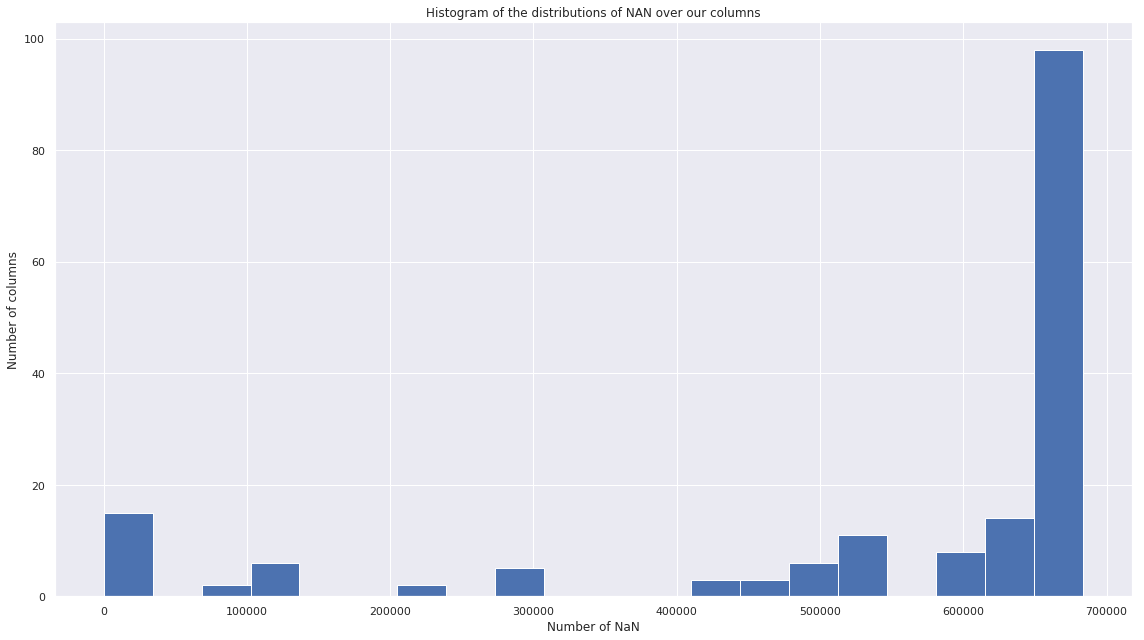

In [5]:
# Implementing the plot of the distributions of NAN over our columns.

plt.figure(figsize=(16,9))
plt.title('Histogram of the distributions of NAN over our columns')
nan_values_per_column.hist(bins=20)
plt.xlabel('Number of NaN')
plt.ylabel('Number of columns')
plt.tight_layout()
plt.show()

We notice that more than 100 columns have more than 600 000 Nan values on around 700 000 entries. We can understand from this that these columns may not be very pertinent.

In [6]:
# A list that contains the features that have more than 600 000 NAN
list_high_nan = list(nan_values_per_column[nan_values_per_column > 600000].index.values)

Let's use the `WordCloud` package to visualise these features with very high amounts of NAN.

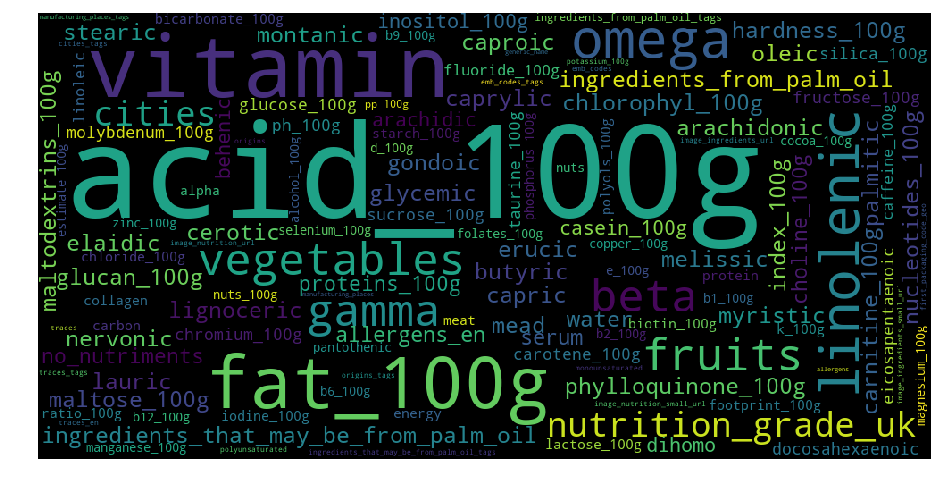

In [7]:
# convert list to string and generate

# We implement a method in order to do the Worldmap in order to use it again later
def word_map(list_to_wmap):
    """
    list: the list we wish to proceed the worldmap on
    """
    unique_string=(" ").join(list_to_wmap)
    wordcloud = WordCloud(width = 1000, height = 500).generate(unique_string)
    plt.figure(figsize=(16,9))
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.show()
    plt.close()

word_map(list_high_nan)

In [8]:
# How our DataFrame would look like if we remove all the features with the high amounts of NAN.
df_open_food_fact.drop(list_high_nan, axis=1).head()

code                                                url   creator  \
0  0000000000017  http://world-en.openfoodfacts.org/product/0000...   kiliweb   
1  0000000000031  http://world-en.openfoodfacts.org/product/0000...  isagoofy   
2  0000000000123  http://world-en.openfoodfacts.org/product/0000...   kiliweb   
3  0000000000291  http://world-en.openfoodfacts.org/product/0000...   kiliweb   
4  0000000000949  http://world-en.openfoodfacts.org/product/0000...   kiliweb   

    created_t      created_datetime last_modified_t last_modified_datetime  \
0  1529059080  2018-06-15T10:38:00Z      1529059204   2018-06-15T10:40:04Z   
1  1539464774  2018-10-13T21:06:14Z      1539464817   2018-10-13T21:06:57Z   
2  1535737982  2018-08-31T17:53:02Z      1535737986   2018-08-31T17:53:06Z   
3  1534239669  2018-08-14T09:41:09Z      1534239732   2018-08-14T09:42:12Z   
4  1523440813  2018-04-11T10:00:13Z      1523440823   2018-04-11T10:00:23Z   

                product_name quantity packaging           ...            \
0           Vitória crackers      NaN       NaN           ...             
1                      Cacao    130 g       NaN           ...             
2      Sauce Sweety chili 0%      NaN       NaN           ...             
3                  Mendiants      NaN       NaN           ...             
4  Salade de carottes râpées      NaN       NaN           ...             

  fiber_100g proteins_100g salt_100g sodium_100g vitamin-a_100g  \
0        NaN           7.8      1.40    0.551181            NaN   
1        NaN           NaN       NaN         NaN            NaN   
2        NaN           0.2      2.04    0.803150            NaN   
3        NaN           NaN       NaN         NaN            NaN   
4        NaN           0.9      0.42    0.165354            NaN   

  vitamin-c_100g calcium_100g iron_100g nutrition-score-fr_100g  \
0            NaN          NaN       NaN                     NaN   
1            NaN          NaN       NaN                     NaN   
2            NaN          NaN       NaN                     NaN   
3            NaN          NaN       NaN                     NaN   
4            NaN          NaN       NaN                     NaN   

  nutrition-score-uk_100g  
0                     NaN  
1                     NaN  
2                     NaN  
3                     NaN  
4                     NaN  

[5 rows x 60 columns]

We now look at the number of `NAN` for each row and plot its distribution

In [9]:
# Rows containing NAN values
nan_rows = df_open_food_fact.isnull().sum(axis=1).sort_values()
nan_rows.values

array([ 29,  79,  81, ..., 163, 163, 163])

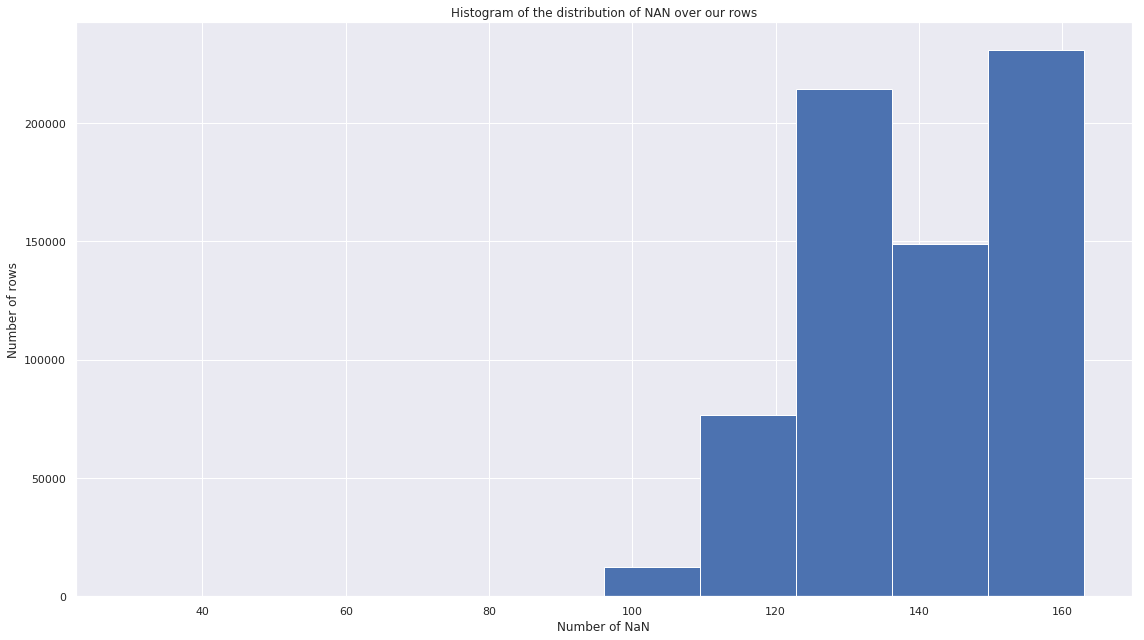

In [10]:
# Implementing the plot of the distributions of NAN over our rows.

plt.figure(figsize=(16,9))
plt.title('Histogram of the distribution of NAN over our rows')
plt.hist(nan_rows.values)
plt.xlabel('Number of NaN')
plt.ylabel('Number of rows')
plt.tight_layout()
plt.show()

We notice that over the rows, we have lots of `NaN` which should not be very surprising due to the number of columns where we almost have only `NaN`.

__Length of rows having less than 100 NAN values in their rows:__

In [11]:
# The length of rows having less than 100 NAN values in their rows
len(nan_rows[nan_rows < 100])

270

There are only _270_ on _695 207 rows_ that have __less__ than _100_ nan values in their columns!

We can clean the dataset by removing the columns that have very high values of NaN.

In [12]:
# We remove the features that have very high number of nan values, but keep some of them that are relevant even if 
# they also  have high numbers of NAN values

features_to_remove = list(nan_values_per_column[nan_values_per_column > 600000].index.values)
features_to_keep = ['allergens', 'ingredients_that_may_be_from_palm_oil',
                    'traces', 'emb_codes', 'origins', 'cities']

# Removing what should be removed and keeping what should be kept
features_to_remove = [item for item in features_to_remove if item not in features_to_keep]
features_to_remove.extend(['code', 'url', 'creator', 'serving_size',  # 'product_name' 
                           'nutrition-score-uk_100g',
                           'last_modified_t', 'last_modified_datetime'])

# When some columns are tags, we remove them because they are redundant
# We add them these redundant columns to the list of columns to remove 
for col in df_open_food_fact.columns.values:
    if '_en' in col:
        features_to_remove.append(col.replace('_en', ''))
    if 'tags' in col:
        features_to_remove.append(col)
        
# The list of redundant columns to remove
features_to_remove = set(list(features_to_remove))
cleaned_df = df_open_food_fact.drop(features_to_remove, axis=1)
cleaned_df.head()

created_t      created_datetime               product_name quantity  \
0  1529059080  2018-06-15T10:38:00Z           Vitória crackers      NaN   
1  1539464774  2018-10-13T21:06:14Z                      Cacao    130 g   
2  1535737982  2018-08-31T17:53:02Z      Sauce Sweety chili 0%      NaN   
3  1534239669  2018-08-14T09:41:09Z                  Mendiants      NaN   
4  1523440813  2018-04-11T10:00:13Z  Salade de carottes râpées      NaN   

  packaging brands categories_en origins labels_en emb_codes  \
0       NaN    NaN           NaN     NaN       NaN       NaN   
1       NaN    NaN           NaN     NaN       NaN       NaN   
2       NaN    NaN           NaN     NaN       NaN       NaN   
3       NaN    NaN           NaN     NaN       NaN       NaN   
4       NaN    NaN           NaN     NaN       NaN       NaN   

            ...             sugars_100g fiber_100g proteins_100g salt_100g  \
0           ...                    15.0        NaN           7.8      1.40   
1           ...                     NaN        NaN           NaN       NaN   
2           ...                     0.4        NaN           0.2      2.04   
3           ...                     NaN        NaN           NaN       NaN   
4           ...                     3.9        NaN           0.9      0.42   

  sodium_100g vitamin-a_100g  vitamin-c_100g calcium_100g  iron_100g  \
0    0.551181            NaN             NaN          NaN        NaN   
1         NaN            NaN             NaN          NaN        NaN   
2    0.803150            NaN             NaN          NaN        NaN   
3         NaN            NaN             NaN          NaN        NaN   
4    0.165354            NaN             NaN          NaN        NaN   

   nutrition-score-fr_100g  
0                      NaN  
1                      NaN  
2                      NaN  
3                      NaN  
4                      NaN  

[5 rows x 44 columns]

#### Correcting some mistakes

#### The energy

We know that the energy a product contains can mainly be calculated through his amount of carbs, fat and proteins. We have :
- 1g of fat => 39 Kj.
- 1g of carbohydrates => 17 Kj.
- 1g of protein => 17 Kj.

By calculating the energy based on the features `fat`, `carbohydrates` and `proteins`, then comparing it to the given value of energy we can detect if some entries are wrong.

__REFERENCE:__
https://2012books.lardbucket.org/books/principles-of-general-chemistry-v1.0/s09-04-thermochemistry-and-nutrition.html

In [13]:
# We get the values of Macros, we compute our own energy and then compute the relative error between our value and 
# the energy given by the dataset

energy_data = cleaned_df.loc[:, ['carbohydrates_100g', 'proteins_100g', 'fat_100g', 'energy_100g']].dropna()
energy_data['calculated_energy'] = 17*energy_data['carbohydrates_100g'] \
                                    + energy_data['proteins_100g'] + 39*energy_data['fat_100g']
energy_data['error(in %)'] = abs(energy_data['calculated_energy']/energy_data['energy_100g']-1) *100
energy_data.head(10)

carbohydrates_100g  proteins_100g  fat_100g  energy_100g  \
0                 70.1            7.8       7.0       1569.0   
2                  4.8            0.2       0.0         88.0   
4                  5.3            0.9       0.3        134.0   
5                 16.3            4.4       4.9        540.0   
8                 38.4           11.7       3.3        929.0   
9                 41.0           12.5       9.4       1213.0   
10                30.3            9.7       5.9        916.0   
11                27.3            4.6      22.0       1594.0   
12                24.0            0.0       0.0        418.0   
13                39.0            7.8      21.0        657.0   

    calculated_energy  error(in %)  
0              1472.5     6.150414  
2                81.8     7.045455  
4               102.7    23.358209  
5               472.6    12.481481  
8               793.2    14.617869  
9              1076.1    11.286068  
10              754.9    17.587336  
11             1326.7    16.769134  
12              408.0     2.392344  
13             1489.8   126.757991

In [14]:
# Small Analysis over these relative errors
print(energy_data['calculated_energy'].describe())
print(10*'--')
print(energy_data['energy_100g'].describe())
print(10*'--')
print(energy_data['error(in %)'].replace([np.inf, -np.inf], np.nan).dropna().describe())

count    5.755560e+05
mean     1.053566e+03
std      6.314687e+03
min     -8.000000e+02
25%      2.949975e+02
50%      9.471900e+02
75%      1.559325e+03
max      2.601967e+06
Name: calculated_energy, dtype: float64
--------------------
count    5.755560e+05
mean     1.171403e+03
std      7.815482e+03
min      0.000000e+00
25%      4.180000e+02
50%      1.096000e+03
75%      1.674000e+03
max      2.845810e+06
Name: energy_100g, dtype: float64
--------------------
count    557598.000000
mean         48.919119
std        1228.061160
min           0.000000
25%           3.607889
50%           9.617248
75%          20.821170
max      509900.000000
Name: error(in %), dtype: float64


We notice that there are some **obvious outliers** :
- there are some **negative values** in the calculated energy
- an energy amount **exceeding 3900kJ** ( the maximum energy amount a product can have is 3900kJ and it corresponds to a product which have 100% of fat, remember that 1g of fat = 39 Kj )

So we delete these products. 

In [15]:
# droping obvious errors
energy_data = energy_data.loc[energy_data.calculated_energy > 0] 
energy_data = energy_data.loc[energy_data.energy_100g < 3900] 
energy_data = energy_data.loc[energy_data.calculated_energy < 3900] 

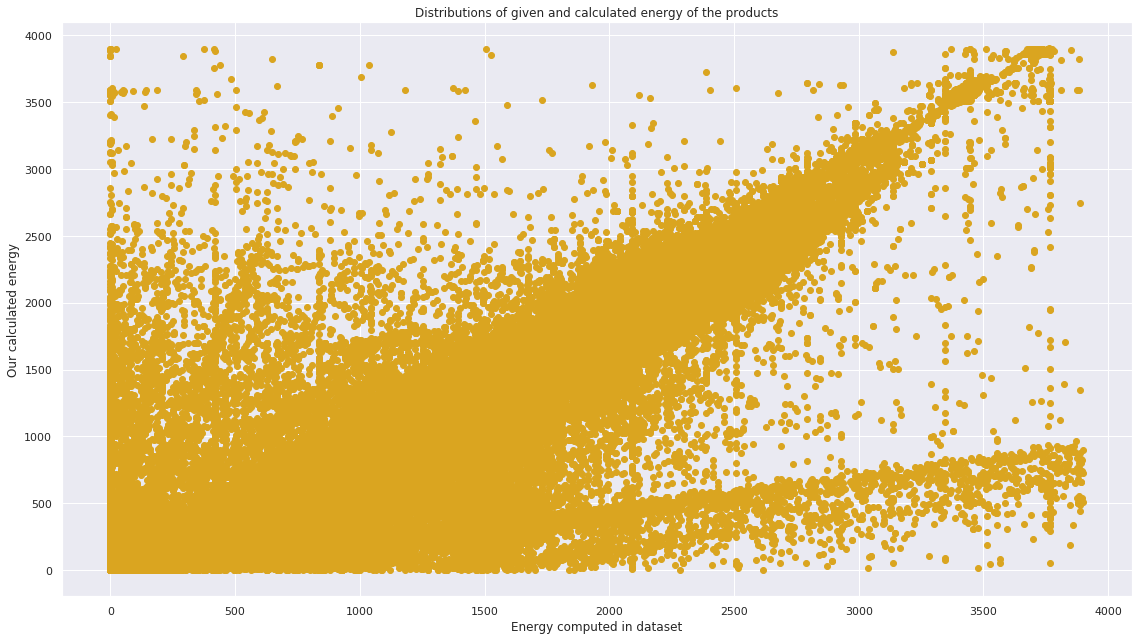

In [16]:
# Visualization of the errors
plt.figure(figsize=(16,9))
plt.title('Distributions of given and calculated energy of the products')
plt.scatter(energy_data["energy_100g"], energy_data["calculated_energy"], c= "goldenrod")
plt.xlabel('Energy computed in dataset')
plt.ylabel('Our calculated energy')
plt.tight_layout()
plt.show()

We notice that there are a lot of calculated energy values that differ from the given energy (values not on the axis `y=x`).  These wrong values may come from wrong input values entered by some users. 

Another suspicious thing we noticed is that in some cases we have __Sum of features > 100g__.
Our features (`carbohydrates`, `proteins` and `fats`) are given based on 100g. Then if the sum of theses features is higher than 100, we can conclude that the user put wrong values. So we can drop these rows.

In [17]:
# We compute the sum over these macros
energy_data["g_sum"] = energy_data['carbohydrates_100g'] + energy_data['proteins_100g'] + energy_data['fat_100g']
# We assign 1 anytime we exceed 100
energy_data["exceeded"] = np.where(energy_data.g_sum.values > 100, 1, 0)
# We count the number of occurences of this issue
energy_data[energy_data.exceeded == 1].count()

carbohydrates_100g    2232
proteins_100g         2232
fat_100g              2232
energy_100g           2232
calculated_energy     2232
error(in %)           2232
g_sum                 2232
exceeded              2232
dtype: int64

There are __2272__ wrong values (sum of the features > 100g), out of 588 209 values. We can drop them.



In [18]:
# new data without 'sum of feature > 100g' error
new_energy_data = energy_data.loc[energy_data.exceeded != 1]

# small analysis with new data 
new_energy_data['error(in %)'].replace([np.inf, -np.inf], np.nan).dropna().describe()

count    548330.000000
mean         46.008912
std        1145.404152
min           0.000000
25%           3.609195
50%           9.614780
75%          20.544505
max      509900.000000
Name: error(in %), dtype: float64

As expected, the percentage of relative errors goes down, suggesting that these wrong values indeed come from wrong input values entered by some users ( 'sum of the features > 100 g', negative values, too high energies ). But there are still high errors. Therefore, we make the choice of deleting energies with **error higher than 14.5%** (corresponding of a quantile of 90%). Now, we will have a better distribution of given and calculated energy of products.

In [19]:
# new data without errors > 14.5%
print('90% quantile : ',energy_data['error(in %)'].replace([np.inf, -np.inf], np.nan).dropna().quantile(0.90))
new_energy_data = new_energy_data.loc[energy_data['error(in %)']<14.5] 

90% quantile :  44.30372965641954


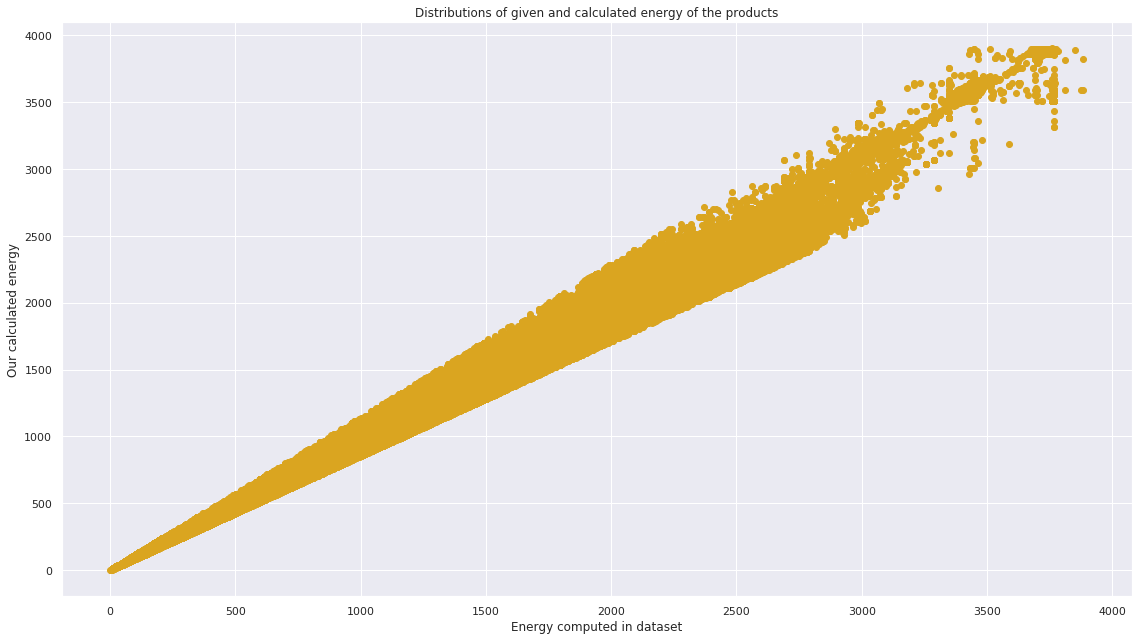

In [20]:
plt.figure(figsize=(16,9))
plt.title('Distributions of given and calculated energy of the products')
plt.scatter(new_energy_data["energy_100g"], new_energy_data["calculated_energy"], c= "goldenrod")
plt.xlabel('Energy computed in dataset')
plt.ylabel('Our calculated energy')
plt.tight_layout()
plt.show()

In [21]:
# Cleaned DATA
ind = list(new_energy_data.index.values) 
cleaned_df = cleaned_df.iloc[ind,:]

For now on, our data is supposed to be __clean__. However, we are aware that it still contains some __NaN and outliers, so before each specific analysis/visualization, we will try to deal with NaN values and outliers in order to stay accurate through the analysis__

## 2. Analysis and Data Visualization

### A. Quality of food

Now that we cleaned the data, we can revisit the features we have and visualize how many `NAN` values they have relatively

_WordMap of the kept columns_

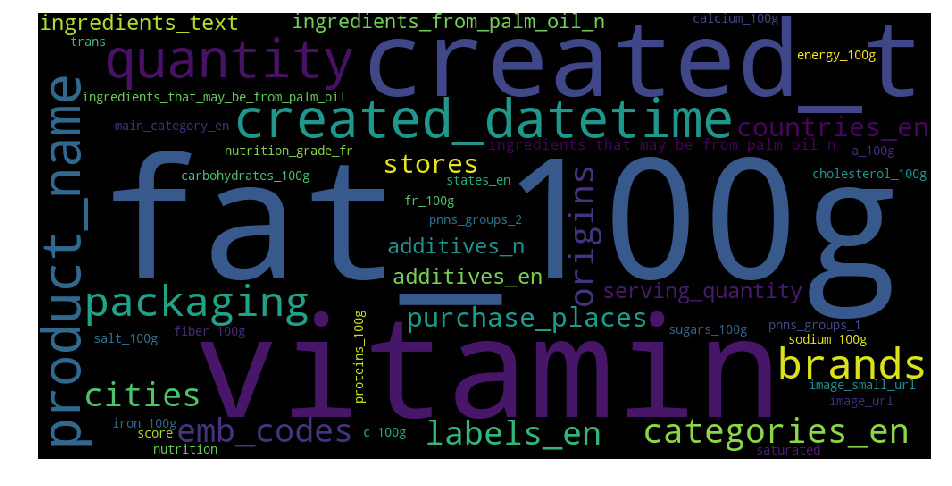

In [22]:
columns_kept = list(cleaned_df.columns.values)
word_map(columns_kept)

Before going through our analysis of _products containing additives_ and _products containing ingredients with palm oil_. We would like to mention that we have noticed that some product categories are written this way :  

`fr:name_category`  

So, we are going to split these columns and keep only the desired `name_category`.

In [23]:
# We first split this column into two different columns with respect to the delimiter, in our case it's ":"
split = cleaned_df['main_category_en'].str.split(":", expand=True)

# Droping unuseful rows
split = split.dropna(how='all')

# We sort the values where we can find "None", since there are categories that are clean (without delimiter)
# the sort is also performed so that these None values can be grouped
# we then register the index of the new sort
idx = split[1].sort_values().index.tolist()

# We sort our dataframe following the sort on the column containing "None".
split = split.loc[idx]
# Since we can't deal with the "None", we replace them by NaNs
split_without_none = split.replace(to_replace='None', value=np.nan).dropna()
# We keep the length of the subarray where we don't have None.
length_without_nan = len(split_without_none)

# Hence since the split has been sorted to group the Nones, we concat following the length we registred above
clean_categories = pd.concat([split.iloc[:len(split)-length_without_nan][1], \
                              split.iloc[len(split)-length_without_nan:][0]], axis=0)

# We register this new cleaned dataframe in a new dataframe 
cleaned_df_cat = cleaned_df.loc[clean_categories.index.tolist()]
cleaned_df_cat['main_category_en'] = clean_categories.values

## Additives

### Products containing additives

__Procedure:__

 - Create a dataframe containing the categories of food and the additives.
 - Perform some investigations for outliers.
 - Make some analysis on the presence of the categories with additives.
 - Focus on two principal metrics : the amounts of additives in products and the average of these.

In [24]:
# We take only the products where we have additives
products_w_additives = cleaned_df_cat.loc[:,['main_category_en','additives_n']].dropna()[cleaned_df_cat.additives_n > 0]

In [25]:
# the following dataframe contains the number of elements in each category where we have additives.
df_category_count = products_w_additives.groupby(['main_category_en', 'additives_n'])['main_category_en'].count()\
                                                                                        .reset_index(name="count")

Let's look for outliers, in order to do that, let's visualize the distribution.

In [26]:
# We look at the products where we have additives and we perform a count to get the distribution afterward
products_w_additives = cleaned_df_cat.loc[:,['main_category_en','additives_n']].dropna()\
                                                        [cleaned_df_cat.additives_n > 0]

df_category_count = products_w_additives.groupby(['main_category_en', 'additives_n'])\
                    ['main_category_en'].count().reset_index(name="count")
    
    
df_category_count_outliers = df_category_count.sort_values('count',ascending=False).reset_index()

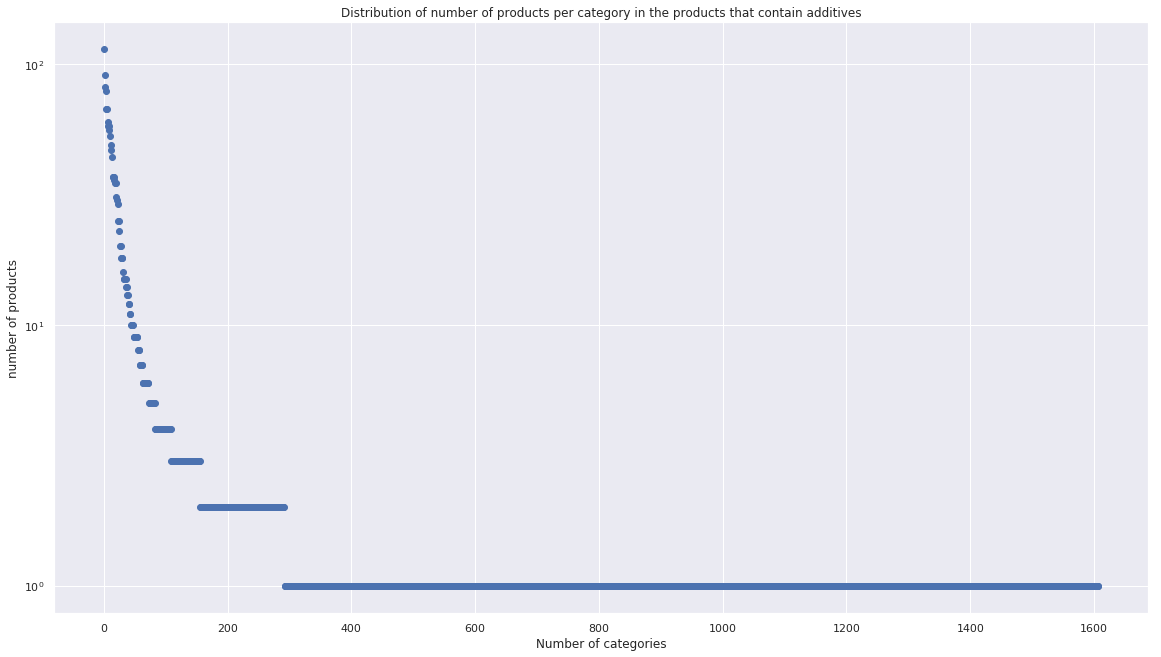

In [27]:
# Plotting the distribution
plt.figure(figsize=(16,9))
plt.title('Distribution of number of products per category in the products that contain additives')
plt.scatter(df_category_count_outliers.index,df_category_count_outliers['count'].values)
plt.tight_layout()
plt.xlabel('Number of categories')
plt.ylabel('number of products')
plt.yscale('Log')

So we clearly notice that we have several outliers where the categories containing additives contains only one product, we will drop these categories to have a better analysis.

In [28]:
# taking the dataframe without outliers
df_products_w_additives_clean = df_category_count.loc[:,['main_category_en','additives_n']].dropna()\
                                [df_category_count['count'] > 1]

In [29]:
# We see the amount of additives that exists for each category
sum_products_w_additives = df_products_w_additives_clean.groupby('main_category_en').sum().\
                        sort_values(by=['additives_n'], ascending=False)

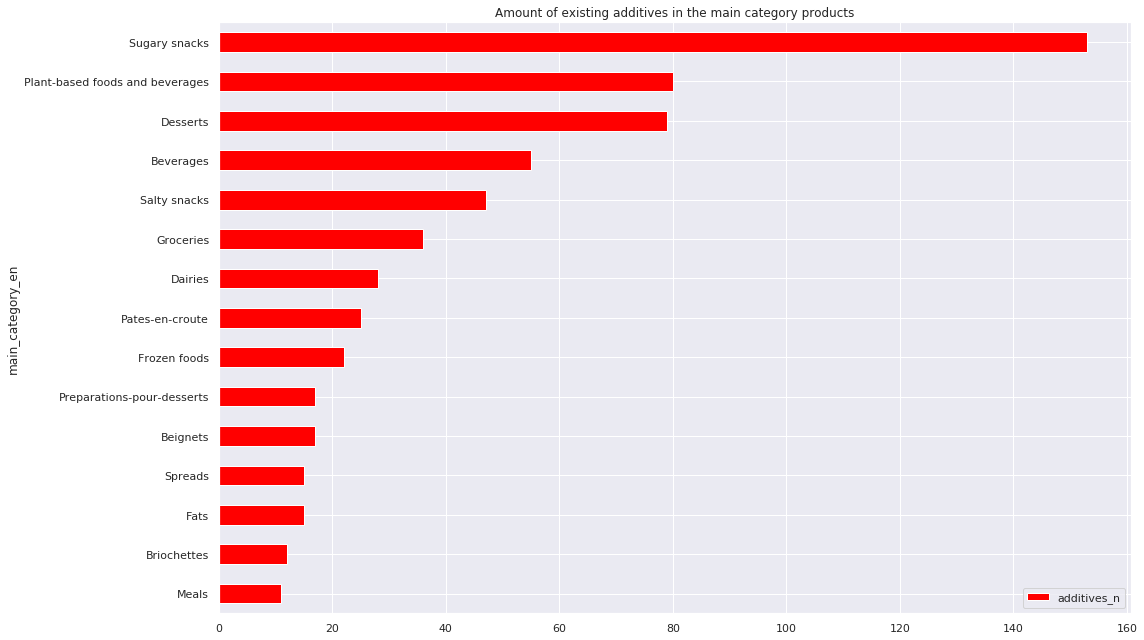

In [30]:
# We plot the amount of additives existing in the main category groupby of products
sum_products_w_additives[:15][::-1].plot(kind='barh', figsize=(16,9), color='red')
plt.title('Amount of existing additives in the main category products')
plt.tight_layout()
plt.show()

We notice that this plot is not really significant because the number of products of each category can greatly differ from a category to an other. Hence, it is preferable to look at the __averaged amounts__ of additives per product in each category.

In [31]:
# We take only the products where we have additives and we look at the average
avg_products_w_additives = df_products_w_additives_clean.groupby('main_category_en').mean().\
                        sort_values(by=['additives_n'], ascending=False)

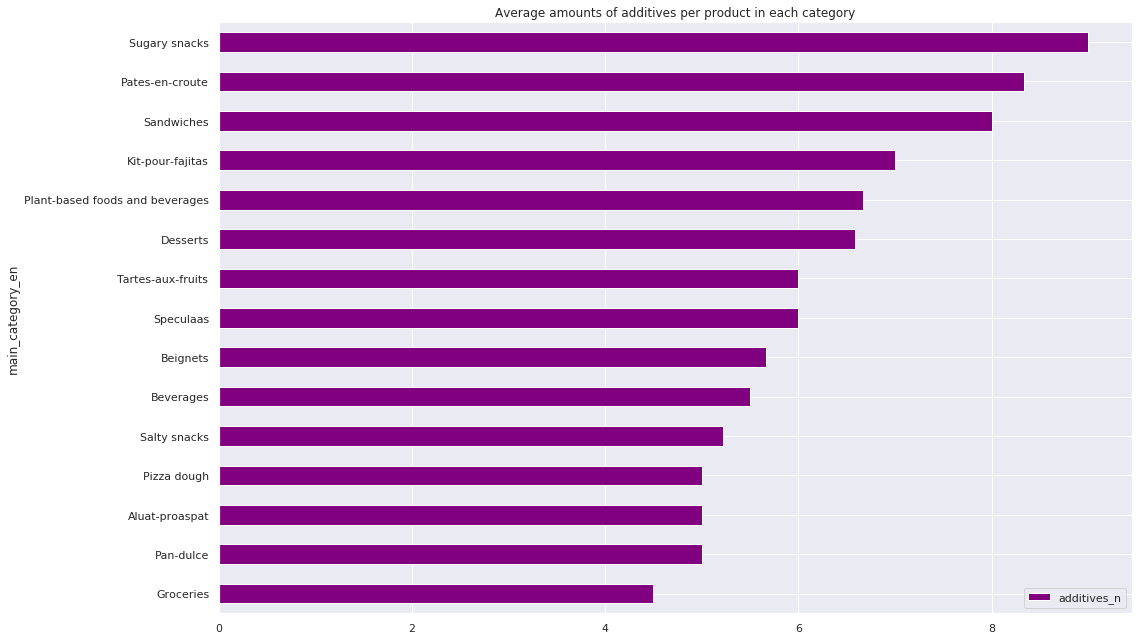

In [32]:
# We plot the average amount of additives existing in the main category groupby of products
avg_products_w_additives[:15][::-1].plot(kind='barh', figsize=(16,9), color='purple')
plt.title('Average amounts of additives per product in each category')
plt.tight_layout()
plt.show()

#### Conclusion :####

As we thought, looking at the average amounts of additives per product in each category is more representative than looking only at the sum of additives over all products per category. We notice some changes for some categories but overall we see that `Sugary snacks`, and `Desserts` are predominant. However, looking at the average, we see some new categories such as `Kit-pour-fajitas`, `tarte-aux-fruits` and `Speculaas`.  

So looking at the average is more meaningful concerning the existence of additives in the categories because it doesnt take into account the number of products registred.

## Palm Oil

### Products containing palm oil

__Procedure:__

 - Create a dataframe containing the categories of food and the palm oil/likely palm oil ingredients.
 - Look at the difference between the likely_palm_oil/surely_palm_oil ingredients
 - Analysis on the difference.
 - Decision of taking the union of the two columns (likely and surely) to take away any doubts.
 - Perform some investigations for outliers.
 - Make some analysis on the presence of the categories with palm oil.
 - Focus on two principal metrics : the amounts of palm oil  in products and the average of these.

Since we have two columns that describe ingredients that are related to palm oil:  
`ingredients_that_may_be_from_palm_oil_n` and `ingredients_from_palm_oil_n`  
Let's have a look at each of these.

In [33]:
likely_palm_oil = cleaned_df_cat[['ingredients_that_may_be_from_palm_oil_n', 'main_category_en']].dropna()
print('number of rows containing products that have ingredients that are likely from palm oil:\
                                                                    '+str(len(likely_palm_oil)))

palm_oil = cleaned_df_cat[['ingredients_from_palm_oil_n', 'main_category_en']].dropna()
print('number of rows containing products that have ingredients that are  from palm oil: '+str(len(palm_oil)))

number of rows containing products that have ingredients that are likely from palm oil:                                                                    6043
number of rows containing products that have ingredients that are  from palm oil: 6043


In [34]:
if set(palm_oil.index) == set(likely_palm_oil.index):
    print("products that likely contain palm oil are exactly the same as the ones that surely contain palm oil")

products that likely contain palm oil are exactly the same as the ones that surely contain palm oil


Well, this means that the products are the same but with different values in the columns :   
`ingredients_that_may_be_from_palm_oil_n` and `ingredients_from_palm_oil_n`  
which tells us that these products can have ingredients where we are sure that they are from palm oil and others where we are not sure about this fact.

<font size="3">Let's look at the __Worldmap__ of categories that surely contains palm oil with minimum of 1 ingredient in order to have an idea of what these are</font> 

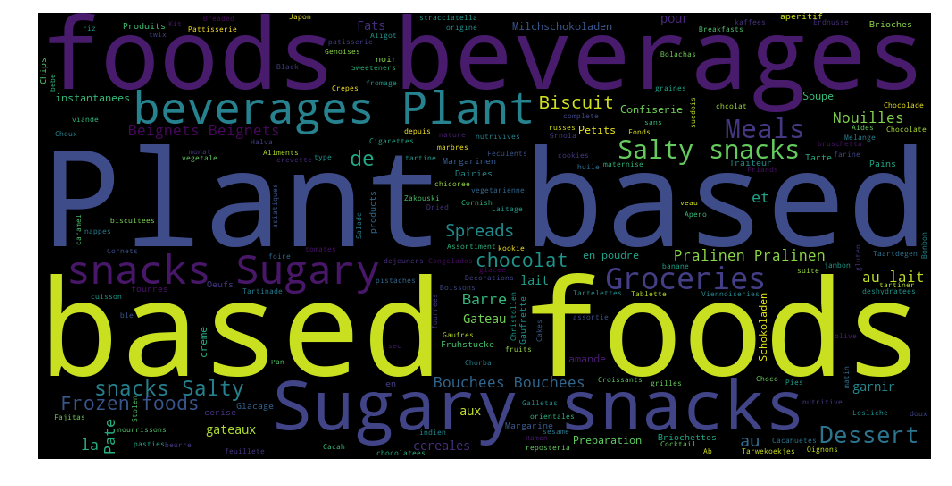

In [35]:
# List to transfrom into Worldmap
palm_oil_min_1_ingredient = palm_oil[palm_oil.ingredients_from_palm_oil_n>=1]
liste = [str(e) for e in cleaned_df_cat.loc[palm_oil_min_1_ingredient.index]['main_category_en'].values.tolist()]
word_map(liste)

<font size="3">let's have a look on the difference between the two columns `'ingredients_that_may_be_from_palm_oil_n` and `ingredients_from_palm_oil_n` </font>

In [36]:
# We create a dataframe where we only have likely_ingredients/surely_ingredients and the  main categories
merge = pd.concat([palm_oil, likely_palm_oil['ingredients_that_may_be_from_palm_oil_n']], axis=1)
# We look at the difference between the likely_ingredients and the surely_ingredients
merge['diff'] = merge.ingredients_that_may_be_from_palm_oil_n-merge.ingredients_from_palm_oil_n

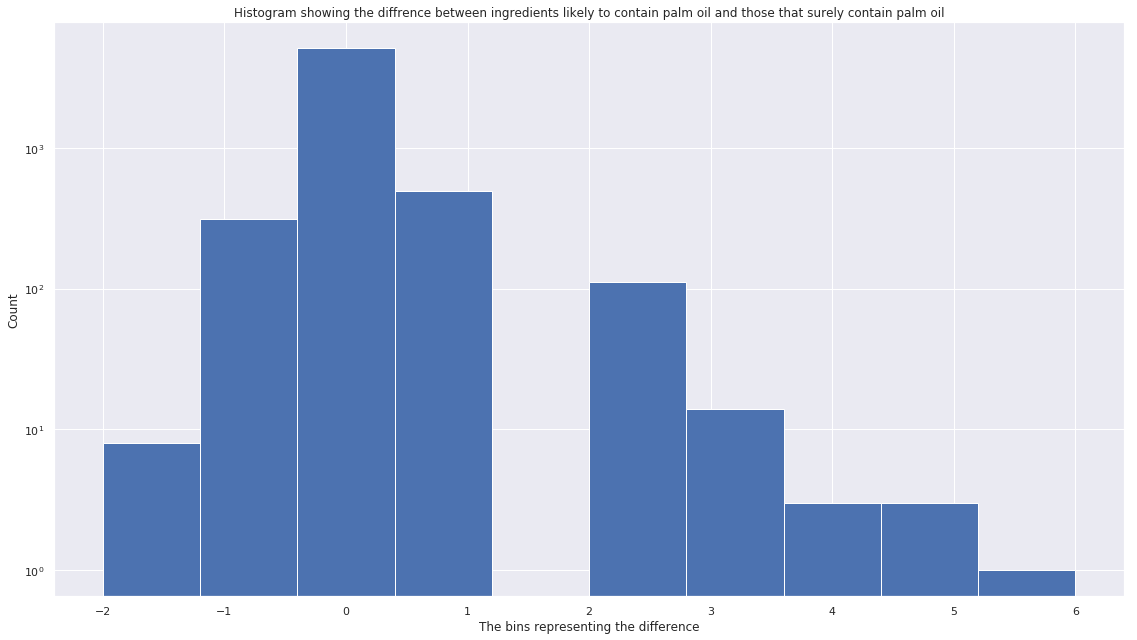

In [37]:
# We look at the distribution of the difference
plt.figure(figsize=(16,9))
plt.title('Histogram showing the diffrence between ingredients likely to contain palm oil and those that surely contain palm oil')
plt.hist(merge['diff'].values)
plt.xlabel('The bins representing the difference')
plt.ylabel('Count')
plt.tight_layout()
plt.yscale('log')

We notice that the two columns are not the same. Furthermore, the difference of number of ingredients between them don't follow a certain distribution. Indeed, ingredients that likely contain palm oil can be different from the ones that surely contain palm oil and vice-versa. In order to deal with this situation, we will take the sum of both columns considered as a union of products containing palm oil.

In [38]:
# Creating the dataframe of the union of the two columns to make analysis
merge['ingredients_palm_oil'] = merge.ingredients_from_palm_oil_n + merge.ingredients_that_may_be_from_palm_oil_n
merge = merge[['ingredients_palm_oil', 'main_category_en']]

Let's have a look at the products where we are sure that there is no palm oil.

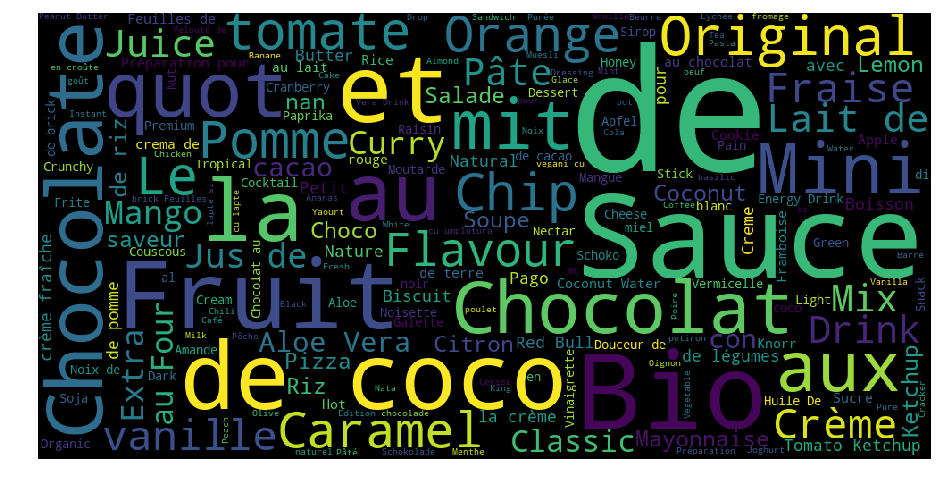

In [39]:
# List of products with NO palm oil
products_with_no_palm_oil = cleaned_df_cat.loc[merge[merge['ingredients_palm_oil'] == 0].index]['product_name'].values.tolist()
to_word_map = [str(e) for e in products_with_no_palm_oil]
word_map(to_word_map)

These results seem to be quite obvious. Indeed, we see lots of fruits, vegetables and non processed meats, we also notice the existence of some organic food. These products are usually clean and don't contain palm oil.

Let's have a look at the distribution of the count of categories that have ingredients from palm oil in order to have an idea about the existence of outliers

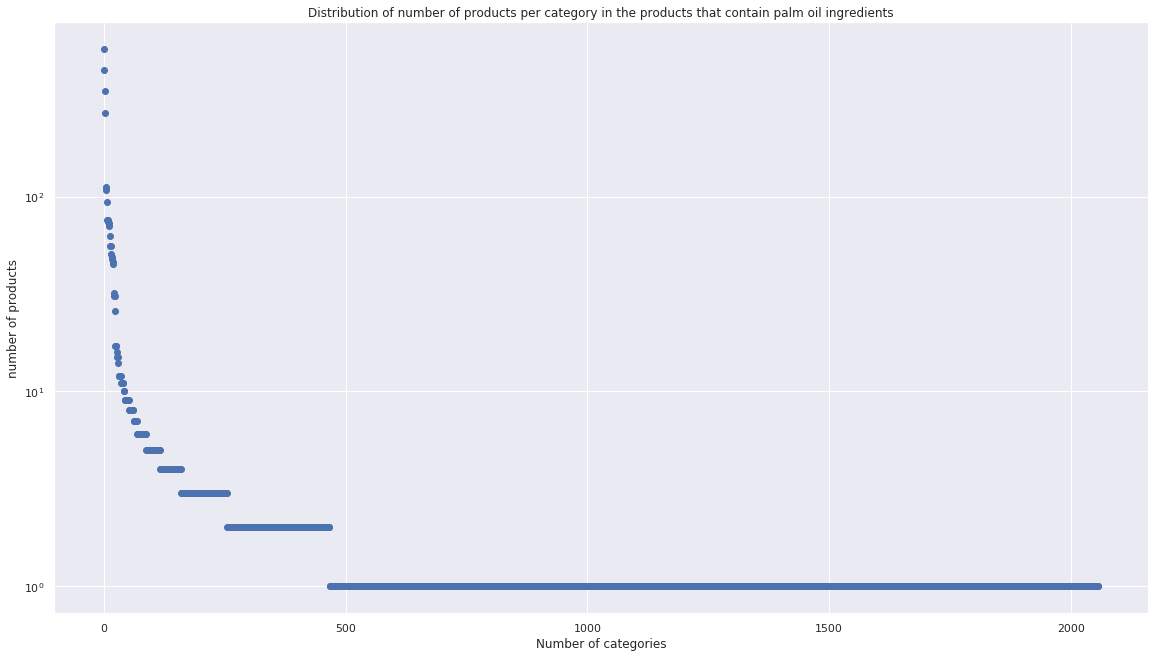

In [40]:
# We compute the count
df_category_count = merge.groupby(['main_category_en', 'ingredients_palm_oil'])\
                    ['main_category_en'].count().reset_index(name="count")
df_category_count_outliers = df_category_count.sort_values('count',ascending=False).reset_index()

# We plot the distribution
plt.figure(figsize=(16,9))
plt.title('Distribution of number of products per category in the products that contain palm oil ingredients')
plt.scatter(df_category_count_outliers.index,df_category_count_outliers['count'].values)
plt.tight_layout()
plt.xlabel('Number of categories')
plt.ylabel('number of products')
plt.yscale('Log')

So just like for additives, we notice the existence of several outliers. dropping them seems the best solution to have a good unbiased analysis. After looking at the Dataframe, we decided to keep only categories that have products containing at least 2 products

In [41]:
# Dealing with outliers
palm_products_clean = df_category_count[df_category_count['count'] > 1]

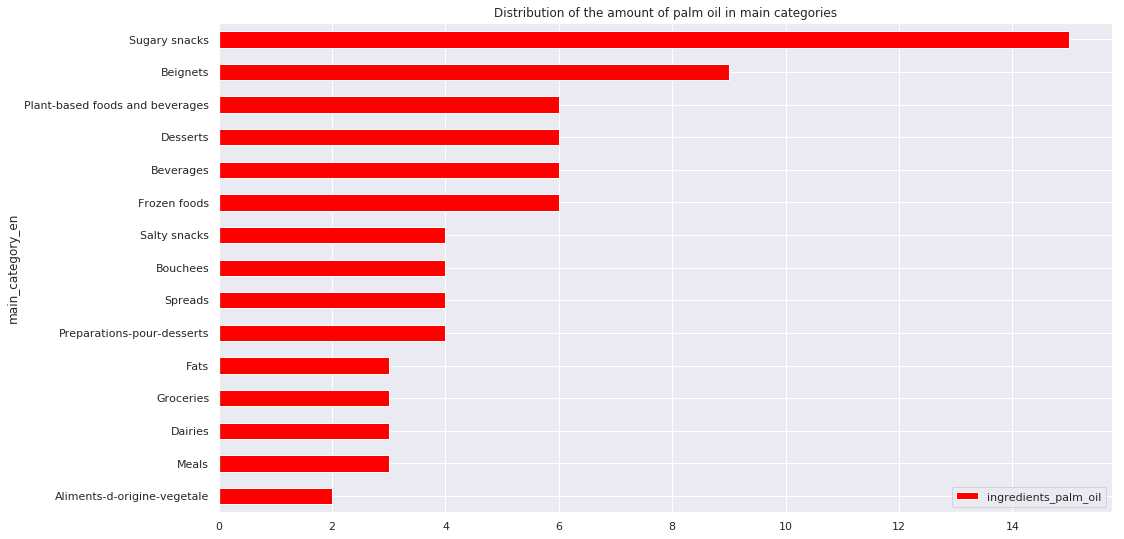

In [42]:
# Clean dataframe with desired columns
palm_products_clean = palm_products_clean[['main_category_en', 'ingredients_palm_oil']]
# We see the amount of additives that exists for each category
sum_palm_oil = palm_products_clean.groupby(['main_category_en']).sum().\
                        sort_values(by=['ingredients_palm_oil'], ascending=False)

# Plot of categories containing additives
sum_palm_oil[:15][::-1].plot(kind='barh', figsize=(16,9), color='red')
plt.title('Distribution of the amount of palm oil in main categories')
plt.show()

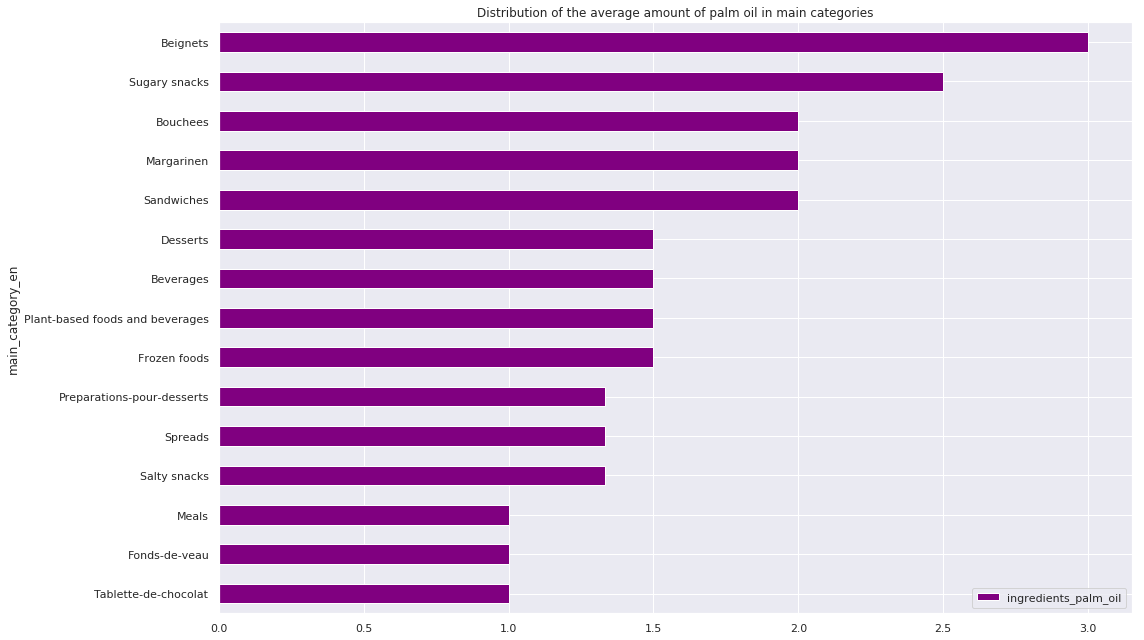

In [43]:
# We see the average amount of additives that exists for each category
mean_palm_oil = palm_products_clean.groupby(['main_category_en']).mean().\
                        sort_values(by=['ingredients_palm_oil'], ascending=False)
mean_palm_oil[:15][::-1].plot(kind='barh', figsize=(16,9), color='purple')
plt.title('Distribution of the average amount of palm oil in main categories')
plt.tight_layout()
plt.show()

These results are really interesting and shows us a second time the importance of looking at the average amount in order to make accurate analysis. Indeed, even if `Sugary snacks` is taking the first place while looking at the amounts in general, `Beignets` take off the first place for the average amounts. Furthermore, we can see that the rankings change  a little bit, some categories such as `Margarinien`, `Sandwiches` that did not exist in the first graph are hardly present in the average amounts. We also would like to mention that `Plant-based foods and beverages` lost several places while looking at the averages.

#### Conclusion :####

It's very important to check the sum of palm oil ingredients over each category but we also have to check the average amounts since this second metric gives us a better idea of the products that are less present in the dataset but with a lots of ingredients coming from palm oil. However, sometimes these categories seem to overlap, this is due to the fact that these categories are predominant in our dataset and are containing lots of palm oil products at the same time.

### Where are these products from ?

#### The represented countries in our dataset

We first create a method that is going to split the columns containing tags with several entries in order to compute more precisely our counts.

In [44]:
def split_tags_df(df, tags_to_split, separator):
    ''' df = dataframe to split,
    target_column = the column containing the values to split
    separator = the symbol used to perform the split

    returns: a dataframe with each entry for the target column separated, with each element moved into a new row. 
    The values in the other columns are duplicated across the newly divided rows.
    '''
    def splitListToRows(row, row_accumulator, tags_to_split, separator):
        split_row = row[tags_to_split].split(separator)
        for s in split_row:
            new_row = row.to_dict()
            new_row[tags_to_split] = s
            row_accumulator.append(new_row)
    new_rows = []
    df = df.dropna(subset=[tags_to_split])
    df.apply(splitListToRows, axis=1, args = (new_rows, tags_to_split, separator))
    new_df = pd.DataFrame(new_rows)
    return new_df

In [45]:
cleaned_df_tags = split_tags_df(cleaned_df_cat, 'countries_en', ',')

We count the number of products of our dataset that are available in each country.

In [46]:
countries_occurences = cleaned_df_tags['countries_en'].dropna().value_counts()

We now plot a figure of the occurences of the countries to see how countries are represented in our dataset

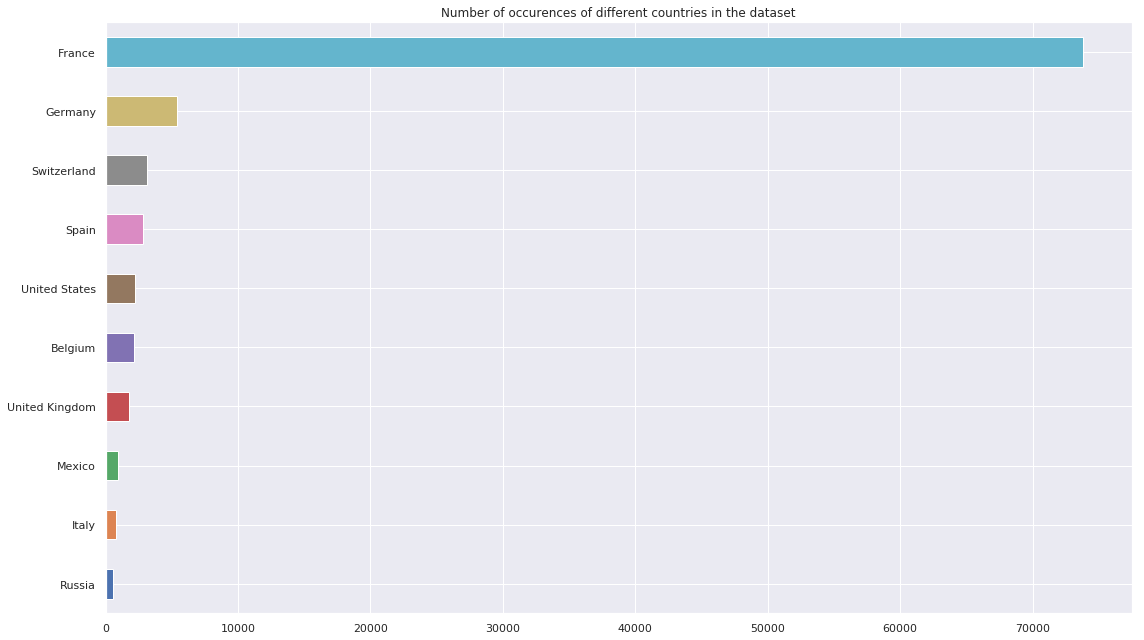

In [47]:
plt.figure(figsize=(16,9))
plt.title('Number of occurences of different countries in the dataset')
countries_occurences[:10][::-1].plot.barh()
plt.tight_layout()
plt.show()

So the two most represented countries are __France__ and the __US__. The problem here is that the number of products from France and the US are so big that we cannot compare in an efficient way with the other countries.

We now want to represent these values on a map using the folium library.
We start by loading a json containing the borders of all the countries of the world.

In [48]:
geo_json_data = json.load(open("world_countries.json",encoding='utf-8'))

We then take the dataframe containing the counts of the products per country, and compute the log of the counts in order to use it in our map. In fact, the log can let us visualize a lot more easily the differences between countries, which would be harder to distinguish because France and the US are predominant.

In [49]:
# we reset the index and rename our columns
products_by_country = countries_occurences.reset_index(name='counts').rename(columns={'index': 'countries_en'})
# in order to clean our dataframe, we remove the entries containing ":" since they represent small amount of our data
products_by_country = products_by_country.drop(products_by_country[products_by_country.countries_en.str.contains(':')].index)
# We compute the logs and sort the dataframe
products_by_country['Log_of_counts'] = np.log(products_by_country['counts'])

When we want to visualize our countries, we need a list of all the countries that we have in order to match our data with it. Since all the names are in english, we don't have a problem of conversion.

In [50]:
all_countries = [element['properties']['name'] for element in geo_json_data['features']]

We are defining a function that we can reuse to generate layers for folium maps.

In [51]:
def generate_folium_map(dataframe, column_counts, name,our_map, column_countries='countries_en', colors=cm.linear.OrRd_03):
    ''' dataframe: dataframe containing the data,
    column_counts = name of the column containing the values to visualize
    name = name given to our layer,
    our_map = folium map to represent the layer on,
    column_countries = name of the column containing the countries

    adds a GeoJson layer to our map to visualize our data
    '''
    
    dataframe = dataframe.reset_index()
    # We separate the countries that we have the data for and the others, in order to put the countries that lack data in grey
    countries_represented = [country for country in dataframe[column_countries].values if country in all_countries]
    countries_not_represented = [country for country in all_countries if country not in countries_represented]
    
    # We define the colormap used to color the map
    max_count = dataframe[column_counts].max()
    min_count = dataframe[column_counts].min()
    colormap = colors.scale(min_count, max_count).to_step(100)
    colormap.caption = name
    
    # We define the color_dict that contains the colors of each country
    color_dict = {key: colormap(dataframe.iloc[i][column_counts]) for i,key in enumerate(list( dataframe[column_countries].values))}
    for country in countries_not_represented:
        color_dict[country] = '#696969'  # Grey
        
    our_map.add_child(colormap)
    
    # We define a function that lets us extract the color of the countries
    def return_color(feature, mapping):
        return mapping[feature["properties"]["name"]]

    # We add the layer to our map
    folium.GeoJson(geo_json_data,
                name=name,
                overlay=False,
              style_function = lambda feature: {
                  'fillColor': return_color(feature, color_dict),
                  'weight': .5,
                  'fillOpacity': .8
              }).add_to(our_map)


We can then use our function to visualize the __log__ of the number of products available in each country

In [52]:
world_map = folium.Map(tiles='cartodbpositron', location=[30,-30], zoom_start=2.5)
folium.GeoJson(geo_json_data).add_to(world_map)
generate_folium_map(products_by_country,"Log_of_counts", "Log of number of Products by country", world_map)
world_map

We clearly see the differences between the countries, and see that France and the US stand out.

We see also that the countries represented in the dataset are numerous, even if most of them only have few products.

__NB__ : The red dot in South America is Guyana which is a French territory, that is why it is red too.

We have seen the distribution of products of the dataset over the countries. However this doesn't give us insight about the safety on our health of these products.
We will study this looking at two sides : additives and palm oil contents.

#### Additives by country

We will start with the amounts of additives in our food, since they are a big health concern. So how are these distributed through the world countries?

In [53]:
# We extract the countries and the data relative to the additives
additives_countries = cleaned_df_tags.loc[:,['countries_en','additives_n']].dropna()
    
# We group the dataframe by countries, and take the sum of ingredients
additives_countries_grouped = additives_countries.groupby('countries_en').sum()

In [54]:
# We drop the entries containing ':' because most of them are irrelevant (example : fr:en and fr:quebec)
additives_countries_grouped = additives_countries_grouped\
        .drop(additives_countries_grouped[additives_countries_grouped.index.str.contains(':')].index)

# We sort the dataframe by the count of ingredients
additives_countries_grouped = additives_countries_grouped.sort_values(by=['additives_n'], ascending=False)

Text(0.5,1,'Occurences of additives in products per countries')

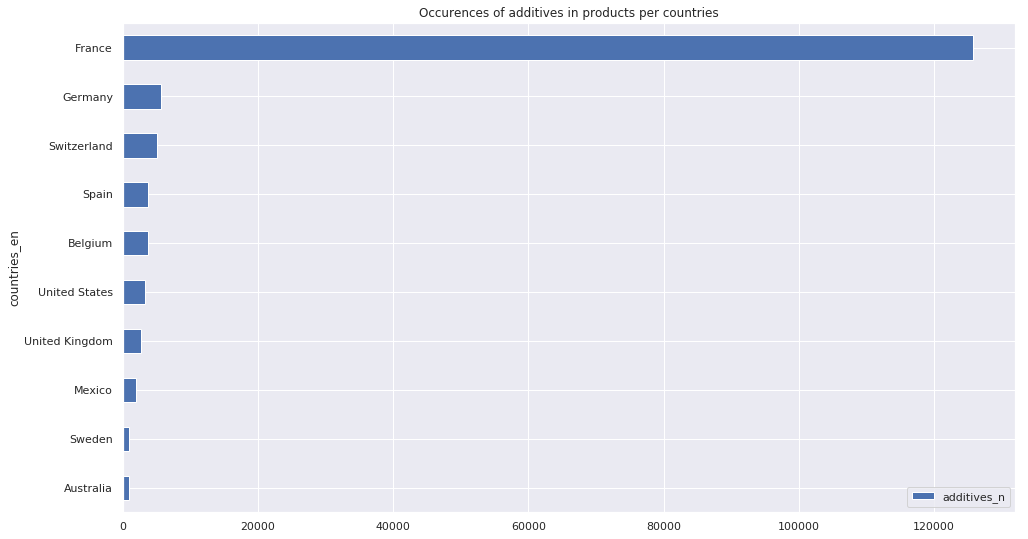

In [55]:
# The distribution of the number of certain products containing additives over the first countries of the dataframe
additives_countries_grouped[:10][::-1].plot(kind='barh', figsize=(16,9))

plt.title('Occurences of additives in products per countries')

Once again, France is predominant over the dataframe. Let's vizualise this data over a map:

We can visualize these countries in a map using the function already defined.
We visualize the __log__ of the number of palm oil ingredients +1 in each country, in order not to have -inf for log(0).

This lets us keep the order between the countries and doesn't alter it, while mapping 0 values to 0.

In [56]:
additives_map = folium.Map(tiles='cartodbpositron',location=[30,-30], zoom_start=2.5)
folium.GeoJson(geo_json_data).add_to(additives_map)

additives_countries_log = additives_countries_grouped
additives_countries_log['Log'] = np.log(additives_countries_log['additives_n']+1)
generate_folium_map(additives_countries_log,"Log",\
                    "Log of the amounts of additives in the products by country",our_map=additives_map,\
                    colors=cm.linear.BrBG_07)

additives_map

We can see once again that France is predominant, followed by far by several other european countries. 
Data is missing for some African, Asian and South American countries as usual.
This map lets us visualize better the distribution of the products containg additives in our dataset. However since the countries are not equally distributed, it is not enough to rely only on the sum of the amounts of additives in the products. Hence we need to check out the averages of additives in the products.

##### Using the averages

In the last map, we used the counts of the ingredients containing additives in each country. However, using the __average__ would be more reprentative, because the number of products entered in the database varies greatly between the countries. But we need first to check the distribution of the number of products containing additives per country:

In [57]:
#We count the number of products per country
additives_countries_count = additives_countries.groupby('countries_en').count()\
                        .sort_values(by=['additives_n'],ascending=False)

# We drop the entry with only 'En' in the country because we can't link it with any country
additives_countries_count = additives_countries_count.drop('En')

#We drop the countries that contain ':'
additives_countries_count = additives_countries_count\
            .drop(additives_countries_count[additives_countries_count.index.str.contains(':')].index)

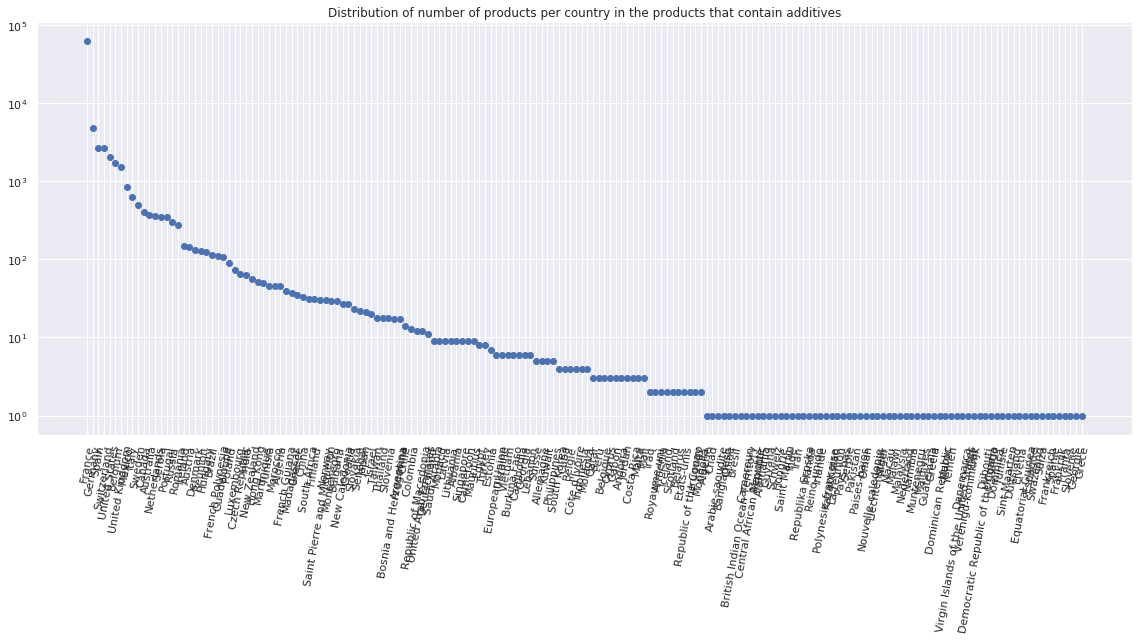

In [58]:
# We plot the distribution
plt.figure(figsize=(16,9))
plt.title('Distribution of number of products per country in the products that contain additives')
plt.scatter(additives_countries_count.index,additives_countries_count['additives_n'].values)
plt.yscale('Log')
plt.xticks(rotation=80)
plt.tight_layout()
plt.show()

We notice that the ranking is similar to the previous one, while many countries only have less than 10 occurences containing information about additives. We can consider them as outliers because computing their average doesn't make any sense, and hence remove them.

In [59]:
# We keep only the ones that have more than 10 entries  
additives_countries_count_outliers = additives_countries_count[additives_countries_count['additives_n']>=10]

additives_countries_avg = additives_countries

# We then take the average of the ingredients from additives for each country
additives_countries_avg = additives_countries_avg.groupby('countries_en').mean()\
                        .sort_values(by=['additives_n'],ascending=False)


# We keep only the countries that have more than 10 entries (the ones left in the dataframe additives_countries_count_outliers)    
additives_countries_avg = additives_countries_avg.loc[additives_countries_count_outliers.index]\
                        .sort_values(by=['additives_n'],ascending=False)

additives_countries_avg.head()

additives_n
countries_en             
Madagascar       4.000000
South Africa     3.129032
Hong Kong        2.843137
Tunisia          2.826087
New Zealand      2.535714

In [60]:
additives_map = folium.Map(tiles='cartodbpositron',location=[30,-30], zoom_start=2.5)
folium.GeoJson(geo_json_data).add_to(additives_map)

generate_folium_map(additives_countries_avg,"additives_n",\
                    "Average additive content of products by country",our_map=additives_map,\
                    colors=cm.linear.BrBG_07)

additives_map

The map becomes very different from the previous one, because now we are not biased anymore by the predominance of one country over the others.

##### Partial conclusion

Using the average number of products with additives gives us a completely new perspective that lets us assert that the results obtained before were only due to the predominance of products from France and other european countries. But since we don't have that much data on the products from countries other than France, we cannot conclude much regarding the countries. We can only see that the average content of additives in French products isn't that high in comparison.

However, what we notice is that we have some African countries that have high rates of ingredients with additives. The reason behind this may be the fact that usually the products entered on Open Food Facts are the ones that are sold in supermarkets. While in Europe you have many industrial healthy products or packaged fruits and vegetables, in Africa in general these types of food are not packaged or labeled indistrually. So they can't be entered on the database.

#### Palm oil by countries

The palm oil content of food is another big health concern, and is highly controversial, because its effects on the human body are not fully known and also becaue its culture generates a lot of deforestation. That's why having the information on products' composition regarding palm oil is very important. So how are the products containing palm oil distributed in the world?

As we have seen when looking at palm oil for the differents categories, we decided to use the union of the ingredients that are surely from palm oil and the ones that are likely from it. But this time instead of categories, we are going to study them for each country.

In [61]:
# We extract the countries and the data relative to the palm oil content
palm_countries = cleaned_df_tags.loc[:,['countries_en','ingredients_from_palm_oil_n','ingredients_that_may_be_from_palm_oil_n']]\
                .dropna()
    
# We group the dataframe by countries, and take the sum of ingredients
palm_countries_grouped = palm_countries.groupby('countries_en').sum()
    
# We drop the one entry with only 'En' in the country because we can't link it with any country
palm_countries_grouped = palm_countries_grouped.drop('En')


In [62]:
# We drop the entries containing ':' because most of them are irrelevant (example : fr:en and fr:quebec)
palm_countries_grouped = palm_countries_grouped.drop(palm_countries_grouped\
                                                     [palm_countries_grouped.index.str.contains(':')].index)

# We compute the number of ingredients in total that are linked with palm oil
palm_countries_grouped['all_ingredients_palm_oil'] = palm_countries_grouped['ingredients_from_palm_oil_n']\
                        + palm_countries_grouped['ingredients_that_may_be_from_palm_oil_n']
    
# We drop the old columns and keep only the union of the two
palm_countries_grouped = palm_countries_grouped.drop(['ingredients_from_palm_oil_n', \
                                                      'ingredients_that_may_be_from_palm_oil_n'], axis=1)
# We sort the dataframe by the count of ingredients
palm_countries_grouped = palm_countries_grouped.sort_values(by=['all_ingredients_palm_oil'], ascending=False)

Text(0.5,1,'Occurences of palm oil in products per countries')

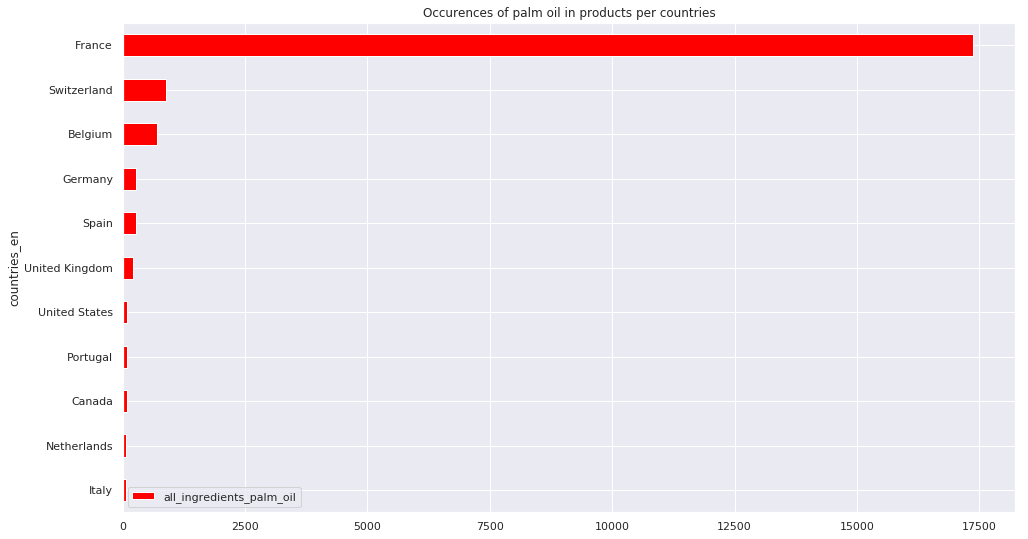

In [63]:
# The distribution of the number of certain products containing palm oil over the first countries of the dataframe
palm_countries_grouped[:11][::-1].plot(kind='barh', figsize=(16,9), color='red')
plt.title('Occurences of palm oil in products per countries')

Once again, France is predominant followed by some european countries.

We can visualize these countries in a map using the function already defined.
We visualize the __log__ of the number of palm oil ingredients +1 in each country, in order not to have -inf for log(0).

Once again, France is predominant over the dataframe, followed by other european countries. Let's vizualise this data over a map:

In [64]:
palm_oil_map = folium.Map(tiles='cartodbpositron',location=[30,-30], zoom_start=2.5)
folium.GeoJson(geo_json_data).add_to(palm_oil_map)

palm_countries_log = palm_countries_grouped
palm_countries_log['Log'] = np.log(palm_countries_log['all_ingredients_palm_oil']+1)
generate_folium_map(palm_countries_log,"Log",\
                    "Log of the sum of ingredients from palm oil in the products by country",our_map=palm_oil_map,\
                    colors=cm.linear.BrBG_07)

palm_oil_map

We clearly see the differences between the countries with the biggest and smallest counts, and see that France stands out, because it is the country that is most represented in the dataset.

Taking the __log__ really helps the vizualisation, while keeping the order.

We see also that the countries not represented in the dataset (in grey) are very numerous this time, and that's mainly because not all the information is available for all products. Most of these countries are in Africa, South America and Asia.

NB : The blue dot in South America is Guyana which is a French territory, that is why it is blue too.

So this data makes it seem as if France has very high contents of palm oil in its products. But is it really the case?

#### Using the averages

In the last map, we used the counts of the ingredients linked to palm oil in each country. However, using the __average__ would be more representative, because the number of products entered in the database varies greatly between the countries. But we need first to check the distribution of the number of products containing palm oil per country:

In [65]:
# We count the number of products per country
palm_countries_count = palm_countries.groupby('countries_en').count()\
                        .sort_values(by=['ingredients_from_palm_oil_n'],ascending=False)

# we keep only one of the two columns rregarding palm oil because they are the same
palm_countries_count = palm_countries_count.rename(columns={'ingredients_from_palm_oil_n': 'count'})
palm_countries_count = palm_countries_count.drop('ingredients_that_may_be_from_palm_oil_n',axis=1)

 
# We drop the entry with only 'En' in the country because we can't link it with any country
palm_countries_count = palm_countries_count.drop('En')

# We drop the countries that contain ':'
palm_countries_count = palm_countries_count.drop(palm_countries_count[palm_countries_count.index.str.contains(':')].index)

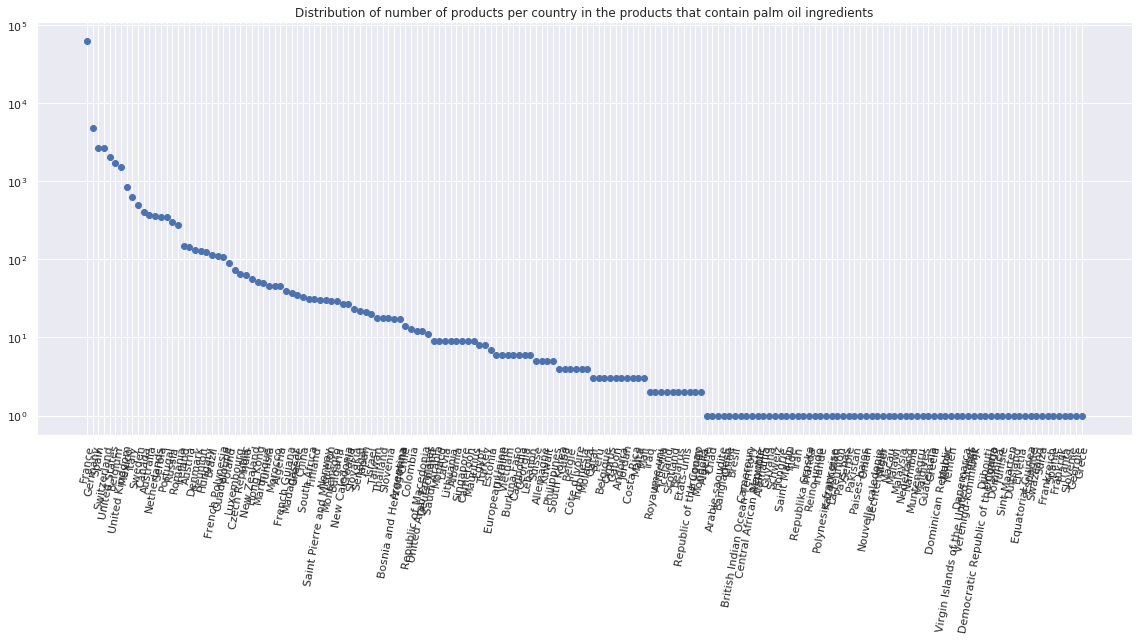

In [66]:
# We plot the distribution
plt.figure(figsize=(16,9))
plt.title('Distribution of number of products per country in the products that contain palm oil ingredients')
plt.scatter(palm_countries_count.index,palm_countries_count['count'].values)
plt.yscale('Log')
plt.xticks(rotation=80)
plt.tight_layout()
plt.show()

We notice that many countries only have less than 40 occurences containing information about palm oil. We can consider them as outliers because computing their average doesn't make any sense, and hence we remove them.

In [67]:
# We keep only the ones that have more than 40 entries  
palm_countries_count_outliers = palm_countries_count[palm_countries_count['count'] > 40]

palm_countries_grouped = palm_countries

# We compute the number of ingredients in total that are linked with palm oil
palm_countries_grouped['all_ingredients_palm_oil'] = (palm_countries_grouped['ingredients_from_palm_oil_n']\
                        + palm_countries_grouped['ingredients_that_may_be_from_palm_oil_n'])

# We drop the old columns and keep only the union of the two
palm_countries_grouped = palm_countries_grouped.drop(['ingredients_from_palm_oil_n',\
                                                    'ingredients_that_may_be_from_palm_oil_n'], axis=1)

# We then take the average of the ingredients from palm oil for each country
palm_countries_grouped = palm_countries_grouped.groupby('countries_en').mean()\
                        .sort_values(by=['all_ingredients_palm_oil'], ascending=False)


# We keep only the countries that have more than 40 entries    
palm_countries_grouped = palm_countries_grouped.loc[palm_countries_count_outliers.index]\
                        .sort_values(by=['all_ingredients_palm_oil'], ascending=False)

In [68]:
palm_oil_map = folium.Map(tiles='cartodbpositron',location=[30,-30], zoom_start=2.5)
folium.GeoJson(geo_json_data).add_to(palm_oil_map)

generate_folium_map(palm_countries_grouped,"all_ingredients_palm_oil",\
                    "Average number of ingredients from palm oil in the products by country",our_map=palm_oil_map,\
                    colors=cm.linear.PuBu_03)

palm_oil_map

The map becomes very different from the previous one, because now we are not biased anymore by the predominance of one country over the others.

### _Conclusion_

**France** and **USA** are the countries that are the most represented in the dataset

**France, Switzerland** and **Belgium** are the countries that have the most products with ingredients containing palm oil. (France probably because it is the most represented country in the dataset). 

Using the average number of products from palm oil gives us a completely new perspective that lets us assert that the results obtained before were only due to the predominance of products from France and the US. But since we don't have that much data on the products from countries other than France, we cannot conclude much regarding the countries.

However, what we notice is that we have some african countries that have high rates of palm oil ingredients. The reason behind this may be the fact that usually the products entered on Open Food Facts are the ones that are sold in supermarkets. While in Europe you have many industrial healthy products or packaged fruits and vegetables, in Africa in general these types of food are not packaged or labeled indistrually. So they can't be entered on the database.

### Nutritional values (A, B, C, D, E)

#### Distribution of quality of products per dominant categories :

In [69]:
# We get the predominant categories
cleaned_df_count_cat = cleaned_df.groupby('main_category_en')['main_category_en'].count().reset_index(name='count')
cleaned_df_count_cat.loc[cleaned_df_count_cat['count'].sort_values(ascending=False).index].head(4)

main_category_en  count
555  Plant-based foods and beverages  20915
688                    Sugary snacks  20761
55                         Beverages  10498
237                          Dairies   4964

Let's now visualize the distribution of the quality of products for these predominants categories in a 4 different subplots.

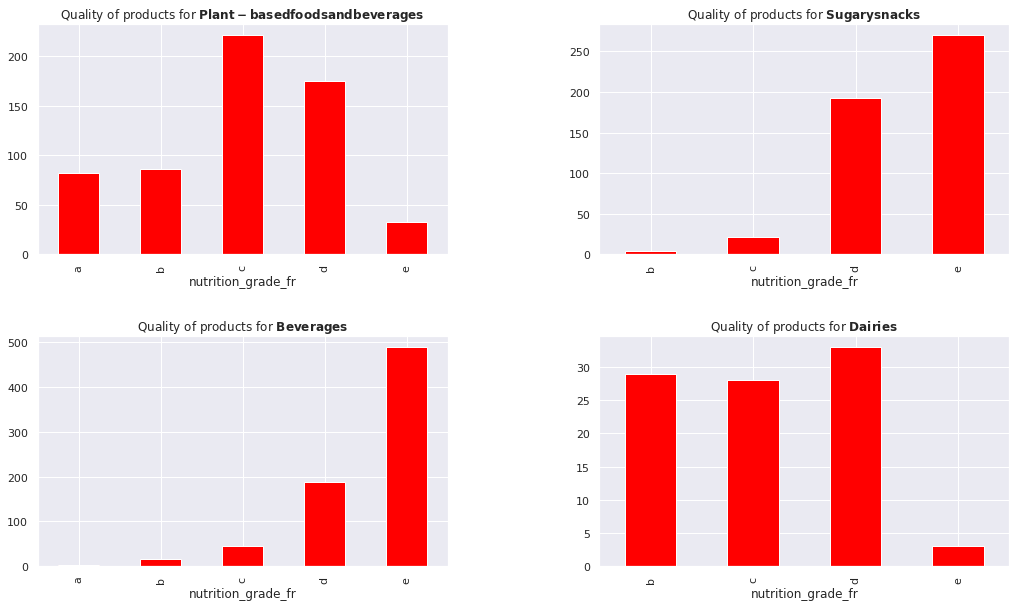

In [70]:
list_main_categories = ['Plant-based foods and beverages', 'Sugary snacks', 'Beverages', 'Dairies']
# The function below is implemented to have several plots for nutrition grade and categories, it will be
# Useful later
def subplot_list(list_subplots, df, dim_sub):
    """
        list_subplots: list of elements of the column dataframe on which we want to proceed subplots
        df: our dataframe
        dim_sub: dimension of our subplots rows*columns
    """
    fig, ax = plt.subplots(dim_sub[0], dim_sub[1])
    ax_list = np.array(ax).flatten().tolist()
    fig.tight_layout()
    for num, cat in enumerate(list_subplots):
        df_test = df[df['main_category_en'] == cat]
        df_test = df_test.groupby(['nutrition_grade_fr'])['nutrition_grade_fr'].count()
        ax_list[num].set_title("Quality of products for "+r"$\bf{"+cat+"}$")
        df_test.plot(kind='bar', figsize=(16,9), color='red', ax=ax_list[num])
        
subplot_list(list_main_categories, cleaned_df_cat, [2,2])

__Interpretation:__


This first approach show us that the `Plant-based-and-Beverages` products have the most number of product with "A". However, this same category have also a good amount of bad products, it is balanced/centred over "C". `Beverages` and `Sugary snacks` seem to be the worst products and `Diaries` are a little bit balanced containing lots of products in "B", "C", "D" and some products in "E" too. This first little approach goes in parallel with our analysis over products containing palm oil and additives.

In order to be more precise, let's look at these distributions for top 3 categories with respect to the averaged amounts for :

- Product with additives
- Product containing ingredients from Palm oil.

__Top three categories of products with additives:__

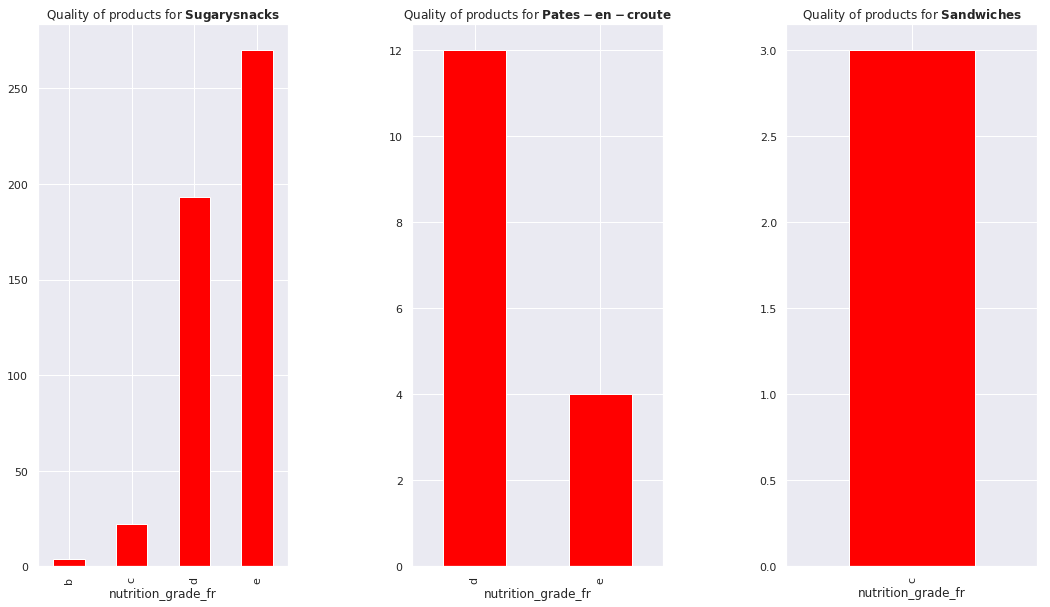

In [71]:
top_3_avg_additives = ['Sugary snacks', 'Pates-en-croute', 'Sandwiches']
subplot_list(top_3_avg_additives, cleaned_df_cat, [1,3])

__Top three categories of products with palm oil ingredient:__

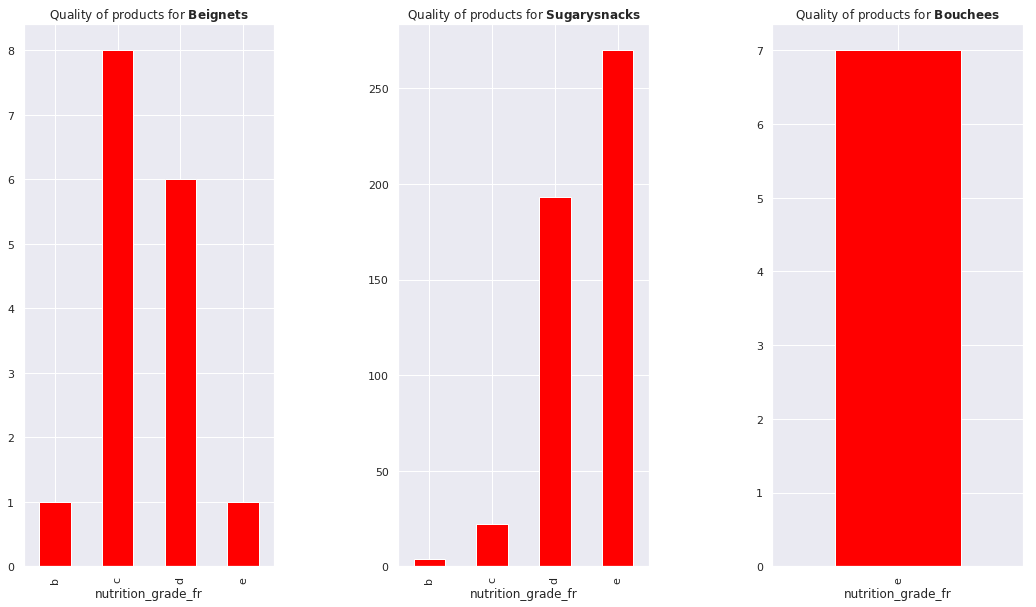

In [72]:
top_3_avg_palm_oil = ['Beignets', 'Sugary snacks', 'Bouchees']
subplot_list(top_3_avg_palm_oil, cleaned_df_cat, [1,3])

__Interpretation:__

Following our previous analysis, it seems that categories with products containing additives and palm oil match quite well. Indeed, our top 3 palm oil and additives products have mostly bad products with some exceptions for `Beignets` and `Sandwiches` that have "C" products. Furthermore, we would like to mention that we have taken into account the average amounts, that's why we have these categories that don't contain lots of products (we considered only products that have equal or more than 2 elements in their categories while analysing outliers). So having a certain quality of products in such not really representative categories doesnt mean that these categories tend to have only thiese qualities of products.  


Related to the two following remarks :

- Knowing that `Sandwiches` are in our top 3 products with additives and have only "C" products. 
- some products in `Beignets` are considered quite good knowing that they are full of palm oil 

We want to dig into other features to see how these can define good/bad products. So the features we are going to investigate are : `proteins`, `fat`, `saturated-fat`, `carbohydrates`, `sugar`, `salt/sodium`.

*NB : We are going to focus only on `salt` and don't take into account the `sodium` because it has very small variance that is fooling our data.

First, lets' have a look at some healthy products in form of a spyder as well as some bad products, the aim is to have a first idea about how are the macros in these two categories. 

In [73]:
# we separate our dataset into two categories: 
# healthy food with nutrition grade A et bad food with nutrition grade E
healthy_data = cleaned_df_cat[cleaned_df_cat.nutrition_grade_fr=='a']
bad_data = cleaned_df_cat[cleaned_df_cat.nutrition_grade_fr=='e']

In [74]:
# We are interested in the following columns
list_columns = ['fat_100g', 'saturated-fat_100g', 'sugars_100g', 'carbohydrates_100g','proteins_100g', 'salt_100g']

We adapt a script found in stackoverflow to draw a radar plot : 
https://stackoverflow.com/questions/42227409/tutorial-for-python-radar-chart-plot

In [75]:
def spider(values, cat, ax):
    pi = np.pi
    N = len(cat)
    x_as = [n / float(N) * 2 * pi for n in range(N)]
    # for circularity
    values += values[:1]
    x_as += x_as[:1]
    # Set color of axes
    plt.rc('axes', linewidth=0.5, edgecolor="#888888")
    # Set clockwise rotation. That is:
    ax.set_theta_offset(pi / 2)
    ax.set_theta_direction(-1)
    # Set position of y-labels
    ax.set_rlabel_position(0)
    # Set color and linestyle of grid
    ax.xaxis.grid(True, color="#888888", linestyle='solid', linewidth=0.5)
    ax.yaxis.grid(True, color="#888888", linestyle='solid', linewidth=0.5)
    # Set ticks values and labels    
    ax.set_xticks(x_as[:-1])
    ax.set_xticklabels([])
    ax.set_yticks([0.1, 0.5, 1, 2, 10])
    ax.set_yticklabels(["0.1", "0.5", "1", "2", "10"])
    # Plot data
    ax.plot(x_as, values, linewidth=0, linestyle='solid', zorder=3)
    # Fill area
    ax.fill(x_as, values, 'b', alpha=0.3)
    # Set axes limits
    ax.set_ylim(0, 3)
    # Draw ytick labels to make sure they fit properly
    for i in range(N):
        angle_rad = i / float(N) * 2 * pi
        if angle_rad == 0:
            ha, distance_ax = "center", 3
        elif 0 < angle_rad < pi:
            ha, distance_ax = "left", 3
        elif angle_rad == pi:
            ha, distance_ax = "center", 3
        else:
            ha, distance_ax = "right", 3

        ax.text(angle_rad, 0.2+distance_ax, cat[i], size=10,
                horizontalalignment=ha, verticalalignment="center")

#### Distribution of some principal nutritional features over healthy/unhealthy products:

Visulalisation of distribution of `fat`, `sugar`, `carbohydrates`, `proteins` and `salt` in some **Healthy products**:

Means_values for healthy products:
fat_100g               3.128112
saturated-fat_100g     0.485187
sugars_100g            6.263529
carbohydrates_100g    42.383370
proteins_100g          6.082319
salt_100g              0.168760
dtype: float64


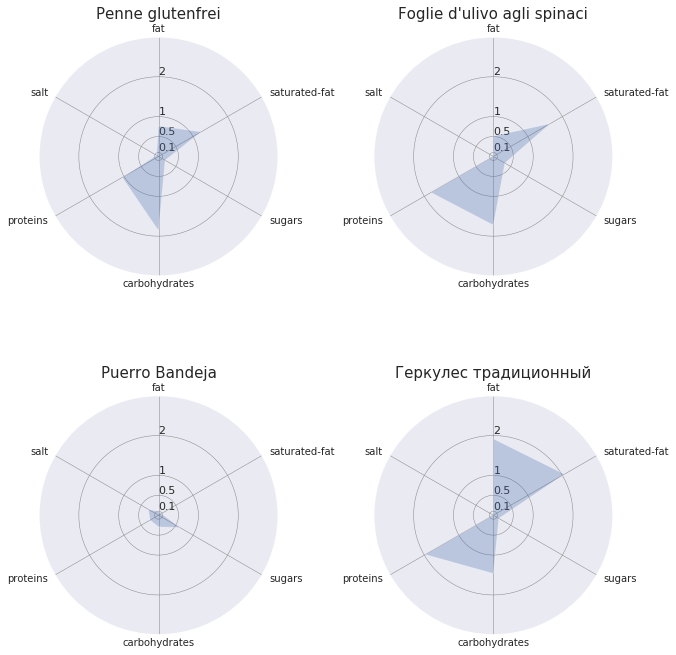

In [76]:
# Healthy data
df_chart = healthy_data[pd.notnull(healthy_data[list_columns]).all(axis = 1)]
mean_columns = healthy_data[list_columns].mean()
print('Means_values for healthy products:')
print(mean_columns)
mean_values = list(mean_columns.values)

# Healthy products 
fig, axes = plt.subplots(nrows=2, ncols=2, subplot_kw=dict(projection='polar'), figsize=(11,11))
axes = np.array(axes)

list_nutriments = [s.strip('_100g') for s in list_columns]

ind = 0
for ax in axes.reshape(-1):
    ind += 1
    ind2 = 3*ind # 
    absolute_values = list(df_chart.iloc[ind2][list_columns].T.values)
    values  = [ val/mean_values[i] for i, val in enumerate(absolute_values)]
    spider(values, list_nutriments, ax)
    ax.set_title(df_chart.iloc[ind2]['product_name'], fontsize = 15)
    
fig.subplots_adjust(hspace=0.5)
plt.show()

Visulalisation of distribution of `fat`, `sugar`, `carbohydrates`, `proteins` and `salt` in some **Bad products** :

Means_values for bad products:
fat_100g              24.109891
saturated-fat_100g    12.666069
sugars_100g           27.516428
carbohydrates_100g    38.242411
proteins_100g          4.833391
salt_100g              2.015046
dtype: float64


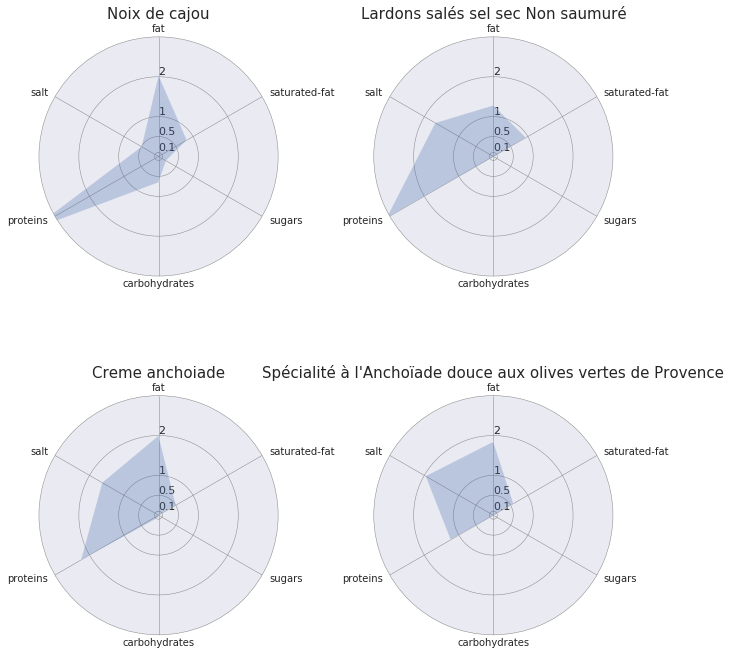

In [77]:
# Bad products 
df_chart = bad_data[pd.notnull(bad_data[list_columns]).all(axis = 1)]
mean_columns = bad_data[list_columns].mean()
print('Means_values for bad products:')
print(mean_columns)
mean_values = list(mean_columns.values)

fig, axes = plt.subplots(nrows=2, ncols=2, subplot_kw=dict(projection='polar'), figsize=(11,11))
axes = np.array(axes)

list_nutriments = [s.strip('_100g') for s in list_columns]

ind = 0
for ax in axes.reshape(-1):
    ind += 1
    ind2 = 10*ind # 
    absolute_values = list(df_chart.iloc[ind2][list_columns].T.values)
    values  = [ val/mean_values[i] for i, val in enumerate(absolute_values)]
    spider(values, list_nutriments, ax)
    ax.set_title(df_chart.iloc[ind2]['product_name'], fontsize = 15)
    
fig.subplots_adjust(hspace=0.5)
plt.show()

__Interpretation:__

We notice after looking at the spyders for heathly/unhealthy products that healthy products seem to have mostly proteins, carbohydrates and some fats but really small amounts of sugar and salt, the oppose it is true for bad products (less important macros and lots of sugar and salt)  

Based on this remark, we will analyse the distribution of these features for healthy as well and unhealthy products. For simplicity, we will consider that :  

- __heathly products : "a" and "b"__
- __unhealthy products : "d" and "e"__

In [78]:
# Healthy products
healthy_data_a_b = cleaned_df_cat[cleaned_df_cat.nutrition_grade_fr.isin(['a', 'b'])]
# Unhealthy products 
bad_data_d_e = cleaned_df_cat[cleaned_df_cat.nutrition_grade_fr.isin(['d', 'e'])]

Let's look at the distributions of the six features we defined before for each healthy/unhealthy products

In [79]:
# We take only the features that interest us 
healthy_data_a_b_features = healthy_data_a_b[list_columns]
unhealthy_data_d_e_features = bad_data_d_e[list_columns]

### Analysis :

__A) FAT:__

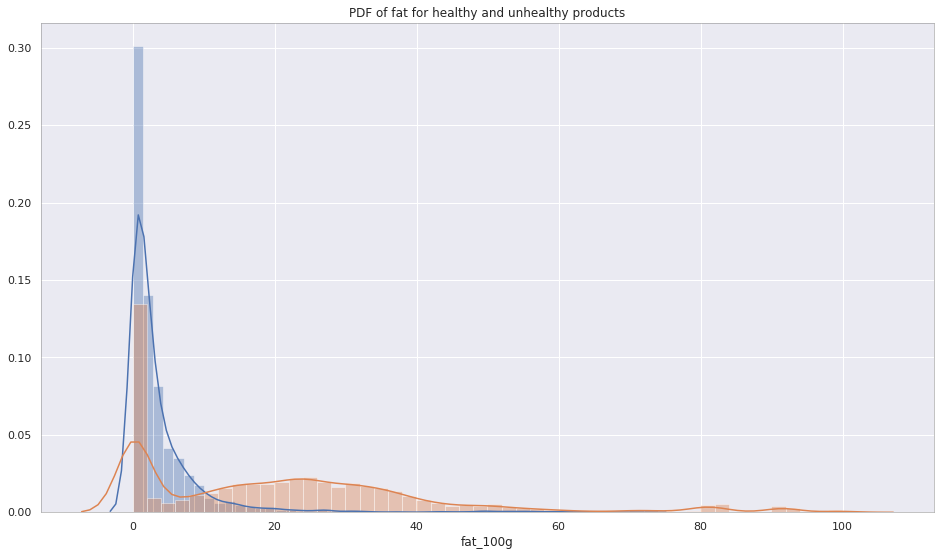

In [80]:
plt.figure(figsize=(16,9))
plt.title('PDF of fat for healthy and unhealthy products')
sns.distplot(healthy_data_a_b_features['fat_100g'], label='Healthy data')
sns.distplot(unhealthy_data_d_e_features['fat_100g'], label='Unhealthy data')
plt.show()

__B) SATURATED FAT:__

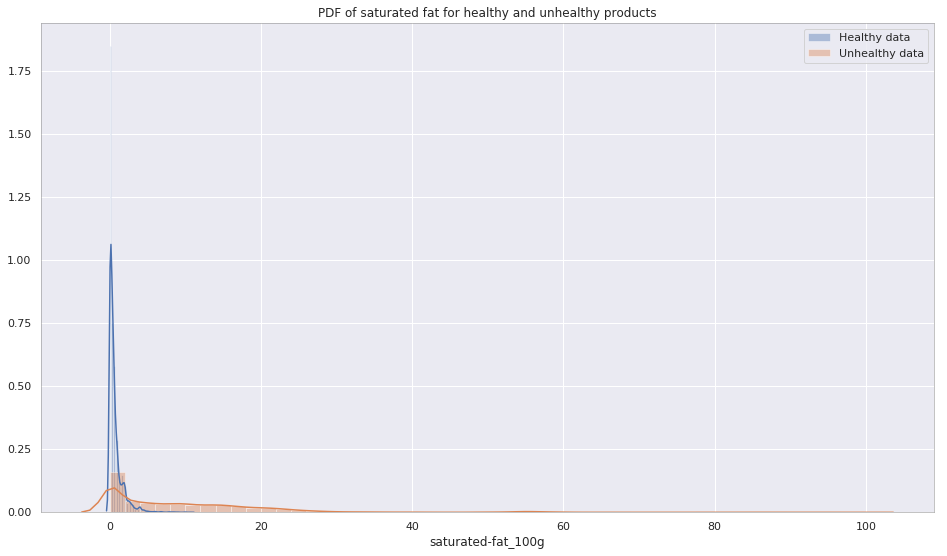

In [81]:
plt.figure(figsize=(16,9))
plt.title('PDF of saturated fat for healthy and unhealthy products')
sns.distplot(healthy_data_a_b_features['saturated-fat_100g'], label='Healthy data')
sns.distplot(unhealthy_data_d_e_features['saturated-fat_100g'], label='Unhealthy data')
plt.legend()
plt.show()

__C) SUGAR:__

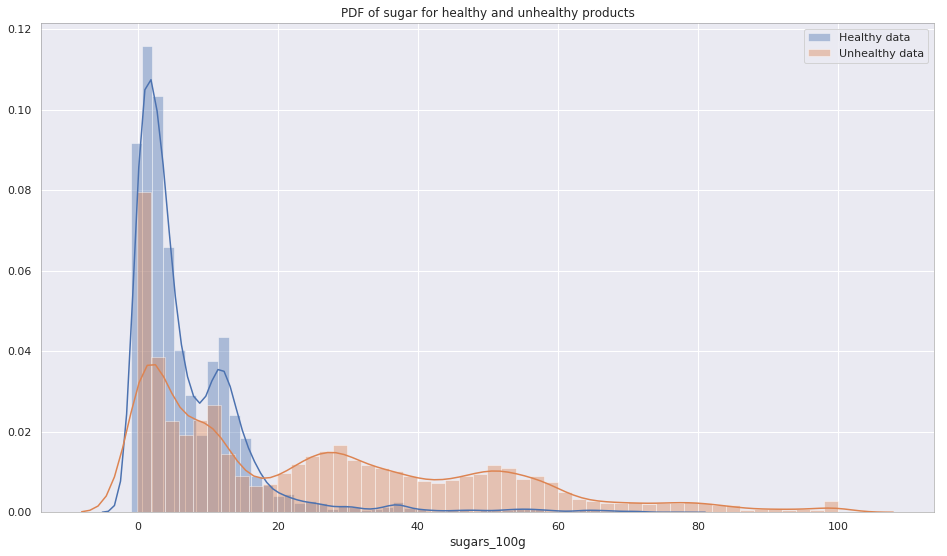

In [82]:
plt.figure(figsize=(16,9))
plt.title('PDF of sugar for healthy and unhealthy products')
sns.distplot(healthy_data_a_b_features['sugars_100g'], label='Healthy data')
sns.distplot(unhealthy_data_d_e_features['sugars_100g'], label='Unhealthy data')
plt.legend()
plt.show()

__Interpretation:__

For __Fat__, __Saturated Fat__, __Sugar__, we make the following comments:

- the density of healthy products have very small dispersion over the mean
- the density of unhealthy products have high dispersion over the mean.
- probability to be around the mean for healthy products is higher than for unhealthy products


We conclude for these features that they seem to be very high in unhealthy products compared to healthy ones.

__D) CARBOHYDRATES:__

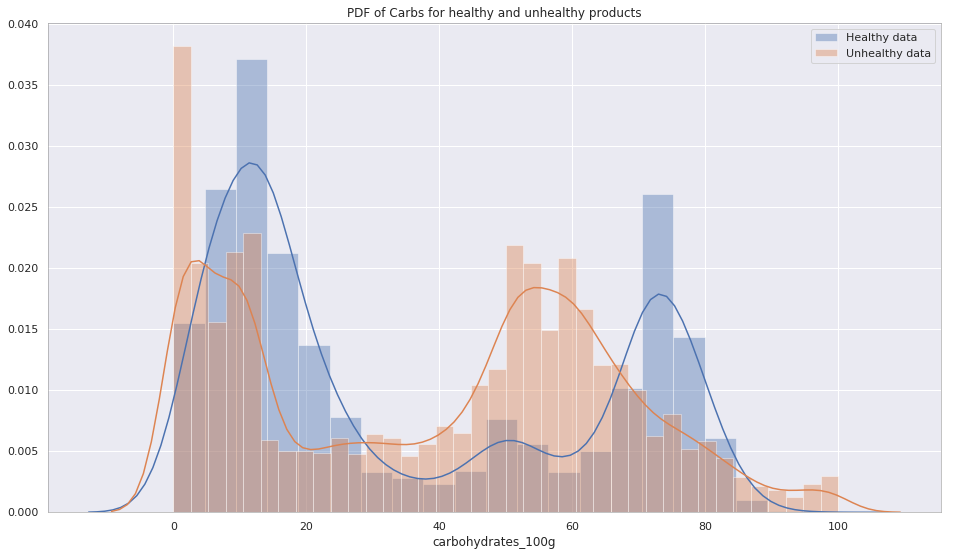

In [83]:
plt.figure(figsize=(16,9))
plt.title('PDF of Carbs for healthy and unhealthy products')
sns.distplot(healthy_data_a_b_features['carbohydrates_100g'], label='Healthy data')
sns.distplot(unhealthy_data_d_e_features['carbohydrates_100g'], label='Unhealthy data')
plt.legend()
plt.show()

__Interpretation:__


We make the following comments for __carbohydrates__:

- the densities look quite the same with a little translation.
- we don't see any unusual difference to mention.

These remarks are reasonnable because carbohydrates are coming either from starchy food/pure sugar or fibres. Some of them (coming from starchy food) will have the tendency to be processed slowly and stored as fat slower than others (pure sugar). That's why we don't see any significant difference between the the healthy/unhealthy products.


__REFERENCE : https://sa.atkins.com/blog/what%E2%80%99s-the-difference-between-carbohydrates-and-sugar-on-food-labels/__

__E) PROTEINS:__

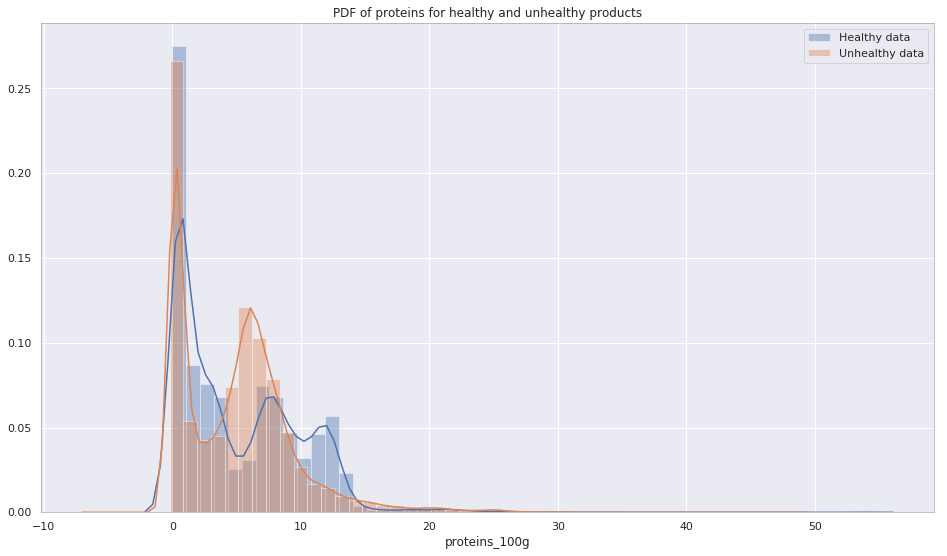

In [84]:
plt.figure(figsize=(16,9))
plt.title('PDF of proteins for healthy and unhealthy products')
sns.distplot(healthy_data_a_b_features['proteins_100g'], label='Healthy data')
sns.distplot(unhealthy_data_d_e_features['proteins_100g'], label='Unhealthy data')
plt.legend()
plt.show()

__Interpretation:__

We can make the following comments for __proteins__:

- The density distributions seem to have slightly the same shape.
- we have more proteined products in heathy products than in unhealthy ones.

We can say that if we look at healthy products versus unhealthy products, the healthy products have the highest amounts of proteins.

__F) SALT:__

In [85]:
# let's see if we have unmeaningful data
len(unhealthy_data_d_e_features[unhealthy_data_d_e_features['salt_100g']>100])

59

We notice that we have some products where the amount of `salt_100g` is supperior than 100g. We have to drop these rows because they don't make sens.

In [86]:
clean_salt_df_un = unhealthy_data_d_e_features[unhealthy_data_d_e_features['salt_100g'] < 100]
clean_salt_df_he = healthy_data_a_b_features[healthy_data_a_b_features['salt_100g'] < 100]

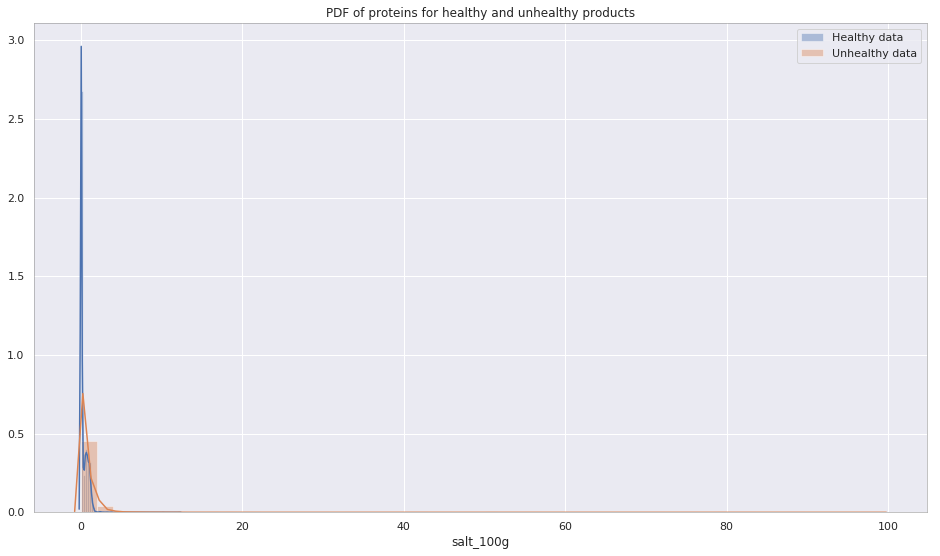

In [87]:
plt.figure(figsize=(16,9))
plt.title('PDF of proteins for healthy and unhealthy products')
sns.distplot(clean_salt_df_he['salt_100g'], label = 'Healthy data')
sns.distplot(clean_salt_df_un['salt_100g'], label = 'Unhealthy data')
plt.legend()
plt.show()

We prefer to plot scatter points in order to look at the difference between salt in healthy/unhealthy products.

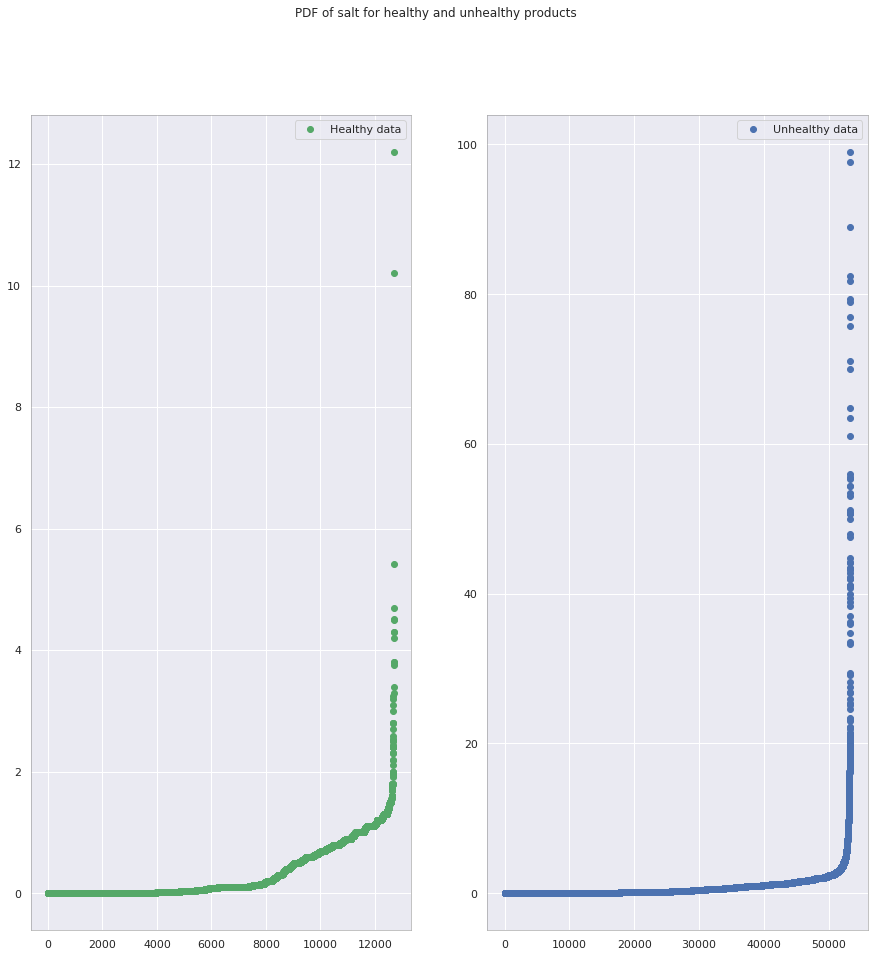

In [88]:
fig, ax = plt.subplots(1,2, figsize=(15,15))
fig.suptitle('PDF of salt for healthy and unhealthy products')
ax[0].plot(clean_salt_df_he['salt_100g'].sort_values().values, 'o', label='Healthy data', color='g')
ax[1].plot(clean_salt_df_un['salt_100g'].sort_values().values, 'o', label='Unhealthy data', color='b')
ax[0].legend()
ax[1].legend()
plt.show()

__Interpretation:__

So, for unhealthy products, we clearly see lots of amounts of salt compared to healthy products.

### B. Carbon footprint

### the goods with the highest carbon foodprint.

In [89]:
df_open_food_fact['carbon-footprint_100g'].describe()

count     342.000000
mean      271.528992
std       405.252492
min        -0.000281
25%         2.300000
50%       150.000000
75%       338.750000
max      2842.000000
Name: carbon-footprint_100g, dtype: float64

In [90]:
# Products containing highest amounts of carbon footprints
carbon_print = df_open_food_fact.loc[:,['categories_en', 'carbon-footprint_100g']]\
                .dropna()[df_open_food_fact['carbon-footprint_100g']>0]
carbon_print = split_tags_df(carbon_print, 'categories_en', ',')
carbon_print.groupby('categories_en').mean().sort_values(by=['carbon-footprint_100g'], ascending=False).head()

carbon-footprint_100g
categories_en                             
Beef                                2520.0
Beef preparations                   2520.0
Meat of the grisons                 2520.0
fr:Saucissons secs                  2380.0
fr:Saucissons                       1610.0

__Interpretation:__


Something interesting is that this carbon footpring tend to get high also with __meats__. Which is something that is very known, lots of studies have showed that meets are inderectly one of the most polluants concerning carbon footprint.

## 3. Advices for customers:

In the next part, we want to get some insights to give advice to the consumer. We are going to use the same split of the data into healthy and unhealthy products -by looking at the ones with the grade A or B and the ones with the grades D and E-.

We are then going to check the labels that these products have predominantly, and use them to give our advice.

##### Healthy prducts

We look first at the products that have a grade of A or B, the best ones:

In [91]:
healthy_data_a_b = cleaned_df_cat[cleaned_df_cat.nutrition_grade_fr.isin(['a','b'])]

We define a function that takes the dataframe, splits the 'labels_en' column, and then counts them using a group by the categories.

In [92]:
def get_labels(df, content='' ):
    '''df : the dataframe to split
       content : the keyword that we want to search for in our categories
       
       returns : the resulting counts
    '''
    df_ = df[df['categories_en'].str.contains(content, case=False)][['categories_en','labels_en']].dropna()
    split_df = split_tags_df(df_, 'labels_en', ',')
    if(not split_df.empty):
        split_df = split_df.groupby('labels_en').count().sort_values(by='categories_en', ascending=False)
    return split_df

We take a first look at the sugary snacks:

In [93]:
split_healthy_sugary = get_labels(healthy_data_a_b, 'Sugary snacks')
split_healthy_sugary.head(7)

categories_en
labels_en                     
Organic                     36
Green Dot                   25
EU Organic                  25
Low or no sugar             20
Vegetarian                  20
Vegan                       18
High fibres                 17

__Interpretation:__

We can see that the snacks that have the best grades are the ones that have labels like __Organic__, __Low Sugar__ or __Vegetarian__. So these labels can be usefule to look for when looking for healthy sugary snacks.

Let's look at some other popular food categories:

In [94]:
get_labels(healthy_data_a_b, 'Beverages').head(7)

categories_en
labels_en                                  
Organic                                2439
EU Organic                             1898
fr:AB Agriculture Biologique           1302
Green Dot                              1273
Vegetarian                              645
Gluten-free                             642
No added sugar                          588

In [95]:
get_labels(healthy_data_a_b, 'meat').head(7)

categories_en
labels_en                         
Organic                         35
Green Dot                       34
EU Organic                      28
Palm oil free                   22
No preservatives                19
fr:Viande Française             18
Made in France                  18

__Interpretation:__

So we see that all the studied categories have labels like __Organic__, __Low Sugar__ or __Vegetarian__, and even __Vegan__ and __Gluten-free__.
So the occurence of these labels on products sold is a good sign that they are healthy.

In the end, the labels found on products can give a good hint about whether it is healthy or not, but to be really sure one needs absoluetly to check all the relevant information about additives, fats, sugar content, palm oil etc.

Let's have a look on the Worldmap of healthy products:

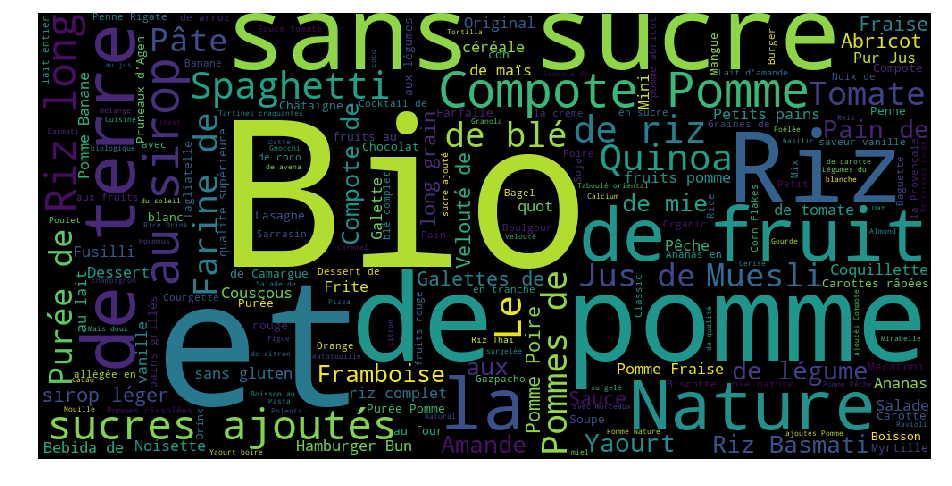

In [96]:
# list of products 
list_to_wm = healthy_data_a_b.product_name.dropna().values

#type(list_to_wm)
word_map(list_to_wm)

__Interpretation:__

Going back to basics is clearly the solution, avoiding unprocessed food, eating fruits and vegetables, unprocessed meats, organic food, avoid sugar and bad fats to stay healthy :)